In [43]:
# ============================================================
# Google Colab Setup — Install everything needed for Task 2 & 3
# ============================================================
import os, sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab — setting up environment...")

    # 1. Install Python packages
    !pip install -q pythainlp matplotlib seaborn pandas numpy networkx ollama

    # 2. Install Thai fonts for matplotlib
    !apt-get install -y fonts-tlwg-sarabun fonts-noto-thai > /dev/null 2>&1
    import matplotlib, shutil, pathlib
    cache_dir = pathlib.Path(matplotlib.get_cachedir())
    if cache_dir.exists():
        shutil.rmtree(cache_dir)
    print("Thai fonts installed.")

    # 3. Install & start Ollama
    !sudo apt-get install -y zstd > /dev/null 2>&1
    !curl -fsSL https://ollama.com/install.sh | sh
    import subprocess, time
    subprocess.Popen(["ollama", "serve"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(5)
    !ollama pull qwen3:8b
    print("Ollama + qwen3:8b ready.")

    # 4. Clone project data from GitHub
    if not os.path.exists('RAG'):
        !git clone https://github.com/warisara29/RAG.git
    os.chdir('RAG')

    print(f"\nSetup complete! Working directory: {os.getcwd()}")
else:
    print("Running locally — skipping Colab setup.")

Running on Google Colab — setting up environment...
Thai fonts installed.
>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.

Ollama + qwen3:8b ready.
Cloning into 'RAG'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 44 (delta 13), reused 36 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 1.13 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (13/13), done.

Setup complete! Working directory: /content/RAG/RAG


# Task 2: Data Collection & Preprocessing
## Thai Criminal Law Q&A Chatbot — PageIndex vs PageIndex + Light Knowledge Graph

**Course:** CS652 Applied Machine Learning  
**Student:** วริศรา พิลาสุข 6809036087  
**Date:** February 2026

---

This notebook covers the data collection and preprocessing phase:
1. Download the Thai Criminal Code dataset
2. Explore and clean the data
3. Parse the hierarchical structure (ภาค > ลักษณะ > หมวด > มาตรา)
4. Extract legal entities for the Knowledge Graph
5. Produce preprocessed files for the PageIndex and KG pipelines

## 1. Setup & Imports

In [44]:
import pandas as pd
import numpy as np
import re
import json
import os
import warnings
from collections import Counter, defaultdict

# Thai NLP
from pythainlp.tokenize import word_tokenize
from pythainlp.util import normalize as thai_normalize
from pythainlp.corpus import thai_stopwords

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# Graph
import networkx as nx

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 120)

print('All imports OK')

All imports OK


In [45]:
# Configure Thai font for matplotlib
thai_font_candidates = ['Sarabun', 'TH Sarabun New', 'Tahoma', 'Noto Sans Thai',
                        'Angsana New', 'Cordia New', 'FreeSans']
available_fonts = {f.name for f in font_manager.fontManager.ttflist}

thai_font = None
for name in thai_font_candidates:
    if name in available_fonts:
        thai_font = name
        break

if thai_font:
    plt.rcParams['font.family'] = thai_font
    print(f'Using Thai font: {thai_font}')
else:
    # Try any font containing 'thai' in the name
    for f in font_manager.fontManager.ttflist:
        if 'thai' in f.name.lower() or 'sarabun' in f.name.lower():
            plt.rcParams['font.family'] = f.name
            thai_font = f.name
            print(f'Using Thai font: {f.name}')
            break
    if not thai_font:
        print('WARNING: No Thai font found. Thai text in plots may not render correctly.')
        print('Consider installing: pip install thai-font  or download Sarabun font')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

Consider installing: pip install thai-font  or download Sarabun font


## 2. Data Acquisition

The Thai Criminal Code (ประมวลกฎหมายอาญา) dataset is sourced from the [PyThaiNLP/thai-law](https://github.com/PyThaiNLP/thai-law) repository.  
Original data is from the Office of the Council of State (สำนักงานคณะกรรมการกฤษฎีกา).  
The data is public domain under Thai Copyright Act Article 7.

In [46]:
DATA_URL = 'https://github.com/PyThaiNLP/thai-law/releases/download/criminal-csv-v0.1/criminal-datasets.csv'
DATA_DIR = 'data'
RAW_FILE = os.path.join(DATA_DIR, 'criminal-datasets.csv')

os.makedirs(DATA_DIR, exist_ok=True)

if not os.path.exists(RAW_FILE):
    import urllib.request
    print(f'Downloading from {DATA_URL}...')
    urllib.request.urlretrieve(DATA_URL, RAW_FILE)
    print(f'Saved to {RAW_FILE}')
else:
    print(f'File already exists: {RAW_FILE}')

File already exists: data/criminal-datasets.csv


In [47]:
df_raw = pd.read_csv(RAW_FILE)
print(f'Shape: {df_raw.shape}')
print(f'Columns: {df_raw.columns.tolist()}')
df_raw.head(10)

Shape: (453, 3)
Columns: ['article', 'text', 'notes']


,article,text,notes
0,intro-1,"มาตรา ๑ พระราชบัญญัตินี้เรียกว่า “พระราชบัญญัติให้ใช้ประมวลกฎหมายอาญา พ.ศ. ๒๔๙๙""",NaN
1,intro-2,มาตรา ๒ พระราชบัญญัตินี้ให้ใช้บังคับตั้งแต่วันถัดจากวันประกาศในราชกิจจานุเบกษาเป็นต้นไป,NaN
2,intro-3,มาตรา ๓ ประมวลกฎหมายอาญาท้ายพระราชบัญญัตินี้ให้ใช้บังคับ ตั้งแต่วันที่ ๑ มกราคม พ.ศ. ๒๕๐๐ เป็นต้นไป,NaN
3,intro-4,มาตรา ๔ เมื่อประมวลกฎหมายอาญาได้ใช้บังคับแล้ว ให้ยกเลิกกฎหมายลักษณะอาญา,NaN
4,intro-5,มาตรา ๕ เมื่อประมวลกฎหมายอาญาได้ใช้บังคับแล้ว ในกรณีที่กฎหมายใดได้กำหนดโทษโดยอ้างถึงโทษฐานลหุโทษในกฎหมายลักษณะอาญาไว...,ถ้าอ้างถึงโทษชั้น ๒ หมายความว่า ปรับไม่เกินห้าร้อยบาท ถ้าอ้างถึงโทษชั้น ๓ หมายความว่า จำคุกไม่เกินสิบวัน หรือปรับไม่...
5,intro-6,มาตรา ๖ เมื่อประมวลกฎหมายอาญาได้ใช้บังคับแล้ว ในการจำคุกแทนค่าปรับตามกฎหมายใด ไม่ว่ากฎหมายนั้นจะบัญญัติไว้ประการใด ...,NaN
6,intro-7,มาตรา ๗ ในกรณีวิธีการเพื่อความปลอดภัยตามมาตรา ๔๖ แห่งประมวลกฎหมายอาญา ให้นำบทบัญญัติแห่งประมวลกฎหมายวิธีพิจารณาความ...,NaN
7,intro-8,มาตรา ๘ เมื่อประมวลกฎหมายอาญาได้ใช้บังคับแล้ว บทบัญญัติแห่งกฎหมายใดอ้างถึงกฎหมายลักษณะอาญา หรืออ้างถึงบทบัญญัติแห่ง...,NaN
8,NaN,NaN,หมายเหตุ :- เหตุผลในการประกาศใช้พระราชบัญญัติฉบับนี้ คือ กฎหมายลักษณะอาญา ร.ศ. ๑๒๗ ได้ประกาศใช้มานานแล้วและได้มีการแ...
9,1,มาตรา ๑ ในประมวลกฎหมายนี้ (๑) “โดยทุจริต” หมายความว่า เพื่อแสวงหาประโยชน์ที่มิควรได้โดยชอบด้วยกฎหมายสำหรับตนเองหรือ...,NaN


## 3. Initial Exploratory Data Analysis

In [48]:
print('=== Data Types ===')
print(df_raw.dtypes)
print(f'\n=== Missing Values ===')
print(df_raw.isnull().sum())
print(f'\nTotal rows: {len(df_raw)}')
print(f'Unique articles: {df_raw["article"].nunique()}')

=== Data Types ===
article    object
text       object
notes      object
dtype: object

=== Missing Values ===
article      1
text         1
notes      228
dtype: int64

Total rows: 453
Unique articles: 451


In [49]:
# Separate intro sections from numbered articles
intro_mask = df_raw['article'].astype(str).str.startswith('intro')
print(f'Intro (preamble) sections: {intro_mask.sum()}')
print(f'Main code entries: {(~intro_mask).sum()}')

print('\n=== Sample intro sections ===')
display(df_raw[intro_mask].head())

print('\n=== Sample main articles ===')
display(df_raw[~intro_mask].head())

Intro (preamble) sections: 8
Main code entries: 445

=== Sample intro sections ===


,article,text,notes
0,intro-1,"มาตรา ๑ พระราชบัญญัตินี้เรียกว่า “พระราชบัญญัติให้ใช้ประมวลกฎหมายอาญา พ.ศ. ๒๔๙๙""",NaN
1,intro-2,มาตรา ๒ พระราชบัญญัตินี้ให้ใช้บังคับตั้งแต่วันถัดจากวันประกาศในราชกิจจานุเบกษาเป็นต้นไป,NaN
2,intro-3,มาตรา ๓ ประมวลกฎหมายอาญาท้ายพระราชบัญญัตินี้ให้ใช้บังคับ ตั้งแต่วันที่ ๑ มกราคม พ.ศ. ๒๕๐๐ เป็นต้นไป,NaN
3,intro-4,มาตรา ๔ เมื่อประมวลกฎหมายอาญาได้ใช้บังคับแล้ว ให้ยกเลิกกฎหมายลักษณะอาญา,NaN
4,intro-5,มาตรา ๕ เมื่อประมวลกฎหมายอาญาได้ใช้บังคับแล้ว ในกรณีที่กฎหมายใดได้กำหนดโทษโดยอ้างถึงโทษฐานลหุโทษในกฎหมายลักษณะอาญาไว...,ถ้าอ้างถึงโทษชั้น ๒ หมายความว่า ปรับไม่เกินห้าร้อยบาท ถ้าอ้างถึงโทษชั้น ๓ หมายความว่า จำคุกไม่เกินสิบวัน หรือปรับไม่...



=== Sample main articles ===


,article,text,notes
8,NaN,NaN,หมายเหตุ :- เหตุผลในการประกาศใช้พระราชบัญญัติฉบับนี้ คือ กฎหมายลักษณะอาญา ร.ศ. ๑๒๗ ได้ประกาศใช้มานานแล้วและได้มีการแ...
9,1,มาตรา ๑ ในประมวลกฎหมายนี้ (๑) “โดยทุจริต” หมายความว่า เพื่อแสวงหาประโยชน์ที่มิควรได้โดยชอบด้วยกฎหมายสำหรับตนเองหรือ...,NaN
10,2,มาตรา ๒ บุคคลจักต้องรับโทษในทางอาญาต่อเมื่อได้กระทำการอันกฎหมายที่ใช้ในขณะกระทำนั้นบัญญัติเป็นความผิดและกำหนดโทษไว้...,NaN
11,3,มาตรา ๓ ถ้ากฎหมายที่ใช้ในขณะกระทำความผิดแตกต่างกับกฎหมายที่ใช้ในภายหลังการกระทำความผิด ให้ใช้กฎหมายในส่วนที่เป็นคุณ...,NaN
12,4,มาตรา ๔ ผู้ใดกระทำความผิดในราชอาณาจักร ต้องรับโทษตามกฎหมาย การกระทำความผิดในเรือไทยหรืออากาศยานไทย ไม่ว่าจะอยู่ ณ ท...,NaN


In [50]:
# Text length analysis
df_raw['text_length'] = df_raw['text'].astype(str).str.len()
print('=== Text Length Statistics ===')
print(df_raw['text_length'].describe())

print(f'\n=== Notes column ===')
print(f'Non-null notes: {df_raw["notes"].notna().sum()}')
print(f'Null notes: {df_raw["notes"].isna().sum()}')
if df_raw['notes'].notna().any():
    print('\nSample notes:')
    display(df_raw[df_raw['notes'].notna()][['article', 'notes']].head(10))

=== Text Length Statistics ===
count     453.000000
mean      356.417219
std       343.877410
min         3.000000
25%       189.000000
50%       269.000000
75%       391.000000
max      3702.000000
Name: text_length, dtype: float64

=== Notes column ===
Non-null notes: 225
Null notes: 228

Sample notes:


,article,notes
4,intro-5,ถ้าอ้างถึงโทษชั้น ๒ หมายความว่า ปรับไม่เกินห้าร้อยบาท ถ้าอ้างถึงโทษชั้น ๓ หมายความว่า จำคุกไม่เกินสิบวัน หรือปรับไม่...
8,NaN,หมายเหตุ :- เหตุผลในการประกาศใช้พระราชบัญญัติฉบับนี้ คือ กฎหมายลักษณะอาญา ร.ศ. ๑๒๗ ได้ประกาศใช้มานานแล้วและได้มีการแ...
130,117,[อัตราโทษ แก้ไขเพิ่มเติมโดยมาตรา ๔ แห่งพระราชบัญญัติแก้ไขเพิ่มเติมประมวลกฎหมายอาญา (ฉบับที่ ๒๖) พ.ศ. ๒๕๖๐]
131,118,[อัตราโทษ แก้ไขเพิ่มเติมโดยมาตรา ๕ แห่งพระราชบัญญัติแก้ไขเพิ่มเติมประมวลกฎหมายอาญา (ฉบับที่ ๒๖) พ.ศ. ๒๕๖๐]
146,133,[อัตราโทษ แก้ไขเพิ่มเติมโดยมาตรา ๕ แห่งพระราชบัญญัติแก้ไขเพิ่มเติมประมวลกฎหมายอาญา (ฉบับที่ ๒๖) พ.ศ. ๒๕๖๐]
147,134,[อัตราโทษ แก้ไขเพิ่มเติมโดยมาตรา ๕ แห่งพระราชบัญญัติแก้ไขเพิ่มเติมประมวลกฎหมายอาญา (ฉบับที่ ๒๖) พ.ศ. ๒๕๖๐]
148,135,[อัตราโทษ แก้ไขเพิ่มเติมโดยมาตรา ๕ แห่งพระราชบัญญัติแก้ไขเพิ่มเติมประมวลกฎหมายอาญา (ฉบับที่ ๒๖) พ.ศ. ๒๕๖๐]
153,136,[อัตราโทษ แก้ไขเพิ่มเติมโดยมาตรา ๕ แห่งพระราชบัญญัติแก้ไขเพิ่มเติมประมวลกฎหมายอาญา (ฉบับที่ ๒๖) พ.ศ. ๒๕๖๐]
154,137,[อัตราโทษ แก้ไขเพิ่มเติมโดยมาตรา ๔ แห่งพระราชบัญญัติแก้ไขเพิ่มเติมประมวลกฎหมายอาญา (ฉบับที่ ๒๖) พ.ศ. ๒๕๖๐]
155,138,[อัตราโทษ แก้ไขเพิ่มเติมโดยมาตรา ๕ แห่งพระราชบัญญัติแก้ไขเพิ่มเติมประมวลกฎหมายอาญา (ฉบับที่ ๒๖) พ.ศ. ๒๕๖๐]


## 4. Data Cleaning

In [51]:
df = df_raw.copy()

# 1. Handle missing values
df['text'] = df['text'].fillna('')
df['notes'] = df['notes'].fillna('')
print(f'Missing values after fill: {df.isnull().sum().sum()}')

# 2. Text normalization using PyThaiNLP
df['text_clean'] = df['text'].apply(lambda x: thai_normalize(str(x)))

# 3. Remove extra whitespace (preserve Thai text structure)
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# 4. Check for duplicates
dup_articles = df['article'].duplicated().sum()
dup_texts = df['text_clean'].duplicated().sum()
print(f'Duplicate article IDs: {dup_articles}')
print(f'Duplicate texts: {dup_texts}')

# 5. Remove empty text rows
empty_mask = df['text_clean'].str.strip() == ''
print(f'Empty text rows: {empty_mask.sum()}')
if empty_mask.sum() > 0:
    df = df[~empty_mask].reset_index(drop=True)

print(f'\nShape after cleaning: {df.shape}')

Missing values after fill: 1
Duplicate article IDs: 1
Duplicate texts: 0
Empty text rows: 1

Shape after cleaning: (452, 5)


## 5. Structural Hierarchy Parsing

The Thai Criminal Code has a hierarchical structure:
- **ภาค** (Book) — ภาค 1 บทบัญญัติทั่วไป, ภาค 2 ความผิด, ภาค 3 ลหุโทษ
- **ลักษณะ** (Title) — groups of related offenses
- **หมวด** (Division) — subdivisions within a title
- **มาตรา** (Section) — individual legal provisions

The CSV contains only flat rows of มาตรา without structural headers.  
We use the **official Thai Criminal Code structure** to map each section to its Book/Title/Division.

In [52]:
# Thai numeral conversion
THAI_DIGITS = '๐๑๒๓๔๕๖๗๘๙'
ARABIC_DIGITS = '0123456789'

def thai_to_arabic(text):
    """Convert Thai numerals to Arabic numerals."""
    for thai, arabic in zip(THAI_DIGITS, ARABIC_DIGITS):
        text = text.replace(thai, arabic)
    return text

def extract_number(text):
    """Extract the first number (Thai or Arabic) from text."""
    converted = thai_to_arabic(str(text))
    match = re.search(r'\d+', converted)
    return int(match.group()) if match else None

# Test
print(thai_to_arabic('มาตรา ๓๙๘'))  # -> มาตรา 398
print(extract_number('๓๙๘'))  # -> 398

มาตรา 398
398


In [53]:
# Official Thai Criminal Code hierarchy mapping
# Each entry: (start_section, end_section, book_num, book_name, title_num, title_name, division_num, division_name)
# Based on the official structure from the Office of the Council of State

HIERARCHY_MAP = [
    # ===== ภาค 1: บทบัญญัติทั่วไป (General Provisions) =====
    # ลักษณะ 1: บทบัญญัติที่ใช้แก่ความผิดทั่วไป
    (1,   1,   1, 'บทบัญญัติทั่วไป', 1, 'บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 1, 'บทนิยาม'),
    (2,   17,  1, 'บทบัญญัติทั่วไป', 1, 'บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 2, 'การใช้กฎหมายอาญา'),
    (18,  38,  1, 'บทบัญญัติทั่วไป', 1, 'บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 3, 'โทษและวิธีการเพื่อความปลอดภัย'),
    (39,  50,  1, 'บทบัญญัติทั่วไป', 1, 'บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 4, 'วิธีการเพื่อความปลอดภัย'),
    (51,  58,  1, 'บทบัญญัติทั่วไป', 1, 'บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 5, 'การเพิ่มโทษ ลดโทษ และการรอการลงโทษ'),
    (59,  79,  1, 'บทบัญญัติทั่วไป', 1, 'บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 6, 'ความรับผิดในทางอาญา'),
    (80,  82,  1, 'บทบัญญัติทั่วไป', 1, 'บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 7, 'การพยายามกระทำความผิด'),
    (83,  89,  1, 'บทบัญญัติทั่วไป', 1, 'บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 8, 'ตัวการและผู้สนับสนุน'),
    (90,  91,  1, 'บทบัญญัติทั่วไป', 1, 'บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 9, 'การกระทำความผิดหลายบทหรือหลายกระทง'),
    (92,  94,  1, 'บทบัญญัติทั่วไป', 1, 'บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 10, 'การกระทำความผิดอีก'),
    (95,  101, 1, 'บทบัญญัติทั่วไป', 1, 'บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 11, 'อายุความ'),
    # ลักษณะ 2: บทบัญญัติที่ใช้แก่ความผิดลหุโทษ
    (102, 106, 1, 'บทบัญญัติทั่วไป', 2, 'บทบัญญัติที่ใช้แก่ความผิดลหุโทษ', None, None),

    # ===== ภาค 2: ความผิด (Offenses) =====
    # ลักษณะ 1: ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร
    (107, 112, 2, 'ความผิด', 1, 'ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร', 1, 'ความผิดต่อองค์พระมหากษัตริย์ พระราชินี รัชทายาท และผู้สำเร็จราชการแทนพระองค์'),
    (113, 118, 2, 'ความผิด', 1, 'ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร', 2, 'ความผิดต่อความมั่นคงของรัฐภายในราชอาณาจักร'),
    (119, 129, 2, 'ความผิด', 1, 'ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร', 3, 'ความผิดต่อความมั่นคงของรัฐภายนอกราชอาณาจักร'),
    (130, 135, 2, 'ความผิด', 1, 'ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร', 4, 'ความผิดต่อสัมพันธไมตรีกับต่างประเทศ'),
    # ลักษณะ 1/1: ความผิดเกี่ยวกับการก่อการร้าย (sections 135/1-135/4 use base=135)
    # These are handled by the slash logic below

    # ลักษณะ 2: ความผิดเกี่ยวกับการปกครอง
    (136, 146, 2, 'ความผิด', 2, 'ความผิดเกี่ยวกับการปกครอง', 1, 'ความผิดต่อเจ้าพนักงาน'),
    (147, 166, 2, 'ความผิด', 2, 'ความผิดเกี่ยวกับการปกครอง', 2, 'ความผิดต่อตำแหน่งหน้าที่ราชการ'),

    # ลักษณะ 3: ความผิดเกี่ยวกับการยุติธรรม
    (167, 199, 2, 'ความผิด', 3, 'ความผิดเกี่ยวกับการยุติธรรม', 1, 'ความผิดต่อเจ้าพนักงานในการยุติธรรม'),
    (200, 205, 2, 'ความผิด', 3, 'ความผิดเกี่ยวกับการยุติธรรม', 2, 'ความผิดต่อตำแหน่งหน้าที่ในการยุติธรรม'),

    # ลักษณะ 4: ความผิดเกี่ยวกับศาสนา
    (206, 208, 2, 'ความผิด', 4, 'ความผิดเกี่ยวกับศาสนา', None, None),

    # ลักษณะ 5: ความผิดเกี่ยวกับความสงบสุขของประชาชน
    (209, 216, 2, 'ความผิด', 5, 'ความผิดเกี่ยวกับความสงบสุขของประชาชน', None, None),

    # ลักษณะ 6: ความผิดเกี่ยวกับการก่อให้เกิดภยันตรายต่อประชาชน
    (217, 239, 2, 'ความผิด', 6, 'ความผิดเกี่ยวกับการก่อให้เกิดภยันตรายต่อประชาชน', None, None),

    # ลักษณะ 7: ความผิดเกี่ยวกับการปลอมและการแปลง
    (240, 249, 2, 'ความผิด', 7, 'ความผิดเกี่ยวกับการปลอมและการแปลง', 1, 'ความผิดเกี่ยวกับเงินตรา'),
    (250, 263, 2, 'ความผิด', 7, 'ความผิดเกี่ยวกับการปลอมและการแปลง', 2, 'ความผิดเกี่ยวกับดวงตรา แสตมป์ และตั๋ว'),
    (264, 269, 2, 'ความผิด', 7, 'ความผิดเกี่ยวกับการปลอมและการแปลง', 3, 'ความผิดเกี่ยวกับเอกสาร'),
    # 269/1-269/15: ความผิดเกี่ยวกับบัตรอิเล็กทรอนิกส์ (handled by slash logic)

    # ลักษณะ 8: ความผิดเกี่ยวกับการค้า
    (270, 275, 2, 'ความผิด', 8, 'ความผิดเกี่ยวกับการค้า', None, None),

    # ลักษณะ 9: ความผิดเกี่ยวกับเพศ
    (276, 287, 2, 'ความผิด', 9, 'ความผิดเกี่ยวกับเพศ', None, None),

    # ลักษณะ 10: ความผิดเกี่ยวกับชีวิตและร่างกาย
    (288, 294, 2, 'ความผิด', 10, 'ความผิดเกี่ยวกับชีวิตและร่างกาย', 1, 'ความผิดต่อชีวิต'),
    (295, 300, 2, 'ความผิด', 10, 'ความผิดเกี่ยวกับชีวิตและร่างกาย', 2, 'ความผิดต่อร่างกาย'),
    (301, 305, 2, 'ความผิด', 10, 'ความผิดเกี่ยวกับชีวิตและร่างกาย', 3, 'ความผิดฐานทำให้แท้งลูก'),
    (306, 308, 2, 'ความผิด', 10, 'ความผิดเกี่ยวกับชีวิตและร่างกาย', 4, 'ความผิดฐานทอดทิ้งเด็ก คนป่วยเจ็บ หรือคนชรา'),

    # ลักษณะ 11: ความผิดเกี่ยวกับเสรีภาพและชื่อเสียง
    (309, 321, 2, 'ความผิด', 11, 'ความผิดเกี่ยวกับเสรีภาพและชื่อเสียง', 1, 'ความผิดต่อเสรีภาพ'),
    (322, 325, 2, 'ความผิด', 11, 'ความผิดเกี่ยวกับเสรีภาพและชื่อเสียง', 2, 'ความผิดฐานเปิดเผยความลับ'),
    (326, 333, 2, 'ความผิด', 11, 'ความผิดเกี่ยวกับเสรีภาพและชื่อเสียง', 3, 'ความผิดฐานหมิ่นประมาท'),

    # ลักษณะ 12: ความผิดเกี่ยวกับทรัพย์
    (334, 336, 2, 'ความผิด', 12, 'ความผิดเกี่ยวกับทรัพย์', 1, 'ความผิดฐานลักทรัพย์และวิ่งราวทรัพย์'),
    (337, 340, 2, 'ความผิด', 12, 'ความผิดเกี่ยวกับทรัพย์', 2, 'ความผิดฐานกรรโชก รีดเอาทรัพย์ ชิงทรัพย์ และปล้นทรัพย์'),
    (341, 348, 2, 'ความผิด', 12, 'ความผิดเกี่ยวกับทรัพย์', 3, 'ความผิดฐานฉ้อโกง'),
    (349, 351, 2, 'ความผิด', 12, 'ความผิดเกี่ยวกับทรัพย์', 4, 'ความผิดฐานโกงเจ้าหนี้'),
    (352, 356, 2, 'ความผิด', 12, 'ความผิดเกี่ยวกับทรัพย์', 5, 'ความผิดฐานยักยอก'),
    (357, 357, 2, 'ความผิด', 12, 'ความผิดเกี่ยวกับทรัพย์', 6, 'ความผิดฐานรับของโจร'),
    (358, 361, 2, 'ความผิด', 12, 'ความผิดเกี่ยวกับทรัพย์', 7, 'ความผิดฐานทำให้เสียทรัพย์'),
    (362, 366, 2, 'ความผิด', 12, 'ความผิดเกี่ยวกับทรัพย์', 8, 'ความผิดฐานบุกรุก'),

    # ===== ภาค 3: ลหุโทษ (Petty Offenses) =====
    (367, 398, 3, 'ลหุโทษ', None, None, None, None),
]

# Special mapping for slash articles (135/x -> ลักษณะ 1/1 ความผิดเกี่ยวกับการก่อการร้าย)
SLASH_OVERRIDES = {
    135: (2, 'ความผิด', '1/1', 'ความผิดเกี่ยวกับการก่อการร้าย', None, None),
    269: (2, 'ความผิด', 7, 'ความผิดเกี่ยวกับการปลอมและการแปลง', 4, 'ความผิดเกี่ยวกับบัตรอิเล็กทรอนิกส์'),
}

def get_base_section(section_num_str):
    """Extract the base section number (before /) as int."""
    return int(section_num_str.split('/')[0])

def map_section_to_hierarchy(section_num_str):
    """Map a section number to its Book/Title/Division using the official structure."""
    is_slash = '/' in section_num_str
    base = get_base_section(section_num_str)

    # Check slash overrides first
    if is_slash and base in SLASH_OVERRIDES:
        ov = SLASH_OVERRIDES[base]
        return {
            'book_num': ov[0], 'book_name': ov[1],
            'title_num': ov[2], 'title_name': ov[3],
            'division_num': ov[4], 'division_name': ov[5],
        }

    # Search in the hierarchy map
    for (start, end, b_num, b_name, t_num, t_name, d_num, d_name) in HIERARCHY_MAP:
        if start <= base <= end:
            return {
                'book_num': b_num, 'book_name': b_name,
                'title_num': t_num, 'title_name': t_name,
                'division_num': d_num, 'division_name': d_name,
            }

    return {
        'book_num': None, 'book_name': None,
        'title_num': None, 'title_name': None,
        'division_num': None, 'division_name': None,
    }

# Test
print(map_section_to_hierarchy('1'))
print(map_section_to_hierarchy('334'))
print(map_section_to_hierarchy('135/1'))
print(map_section_to_hierarchy('269/5'))
print(map_section_to_hierarchy('398'))

{'book_num': 1, 'book_name': 'บทบัญญัติทั่วไป', 'title_num': 1, 'title_name': 'บทบัญญัติที่ใช้แก่ความผิดทั่วไป', 'division_num': 1, 'division_name': 'บทนิยาม'}
{'book_num': 2, 'book_name': 'ความผิด', 'title_num': 12, 'title_name': 'ความผิดเกี่ยวกับทรัพย์', 'division_num': 1, 'division_name': 'ความผิดฐานลักทรัพย์และวิ่งราวทรัพย์'}
{'book_num': 2, 'book_name': 'ความผิด', 'title_num': '1/1', 'title_name': 'ความผิดเกี่ยวกับการก่อการร้าย', 'division_num': None, 'division_name': None}
{'book_num': 2, 'book_name': 'ความผิด', 'title_num': 7, 'title_name': 'ความผิดเกี่ยวกับการปลอมและการแปลง', 'division_num': 4, 'division_name': 'ความผิดเกี่ยวกับบัตรอิเล็กทรอนิกส์'}
{'book_num': 3, 'book_name': 'ลหุโทษ', 'title_num': None, 'title_name': None, 'division_num': None, 'division_name': None}


In [54]:
def parse_all_sections(df):
    """
    Parse all rows: extract section numbers and map to hierarchy.
    Handles intro sections (preamble act) separately.
    """
    records = []

    for idx, row in df.iterrows():
        text = str(row['text_clean']).strip()
        article_id = str(row['article']).strip()

        # Determine if intro or main section
        is_intro = article_id.startswith('intro')

        # Extract section number from text
        section_num = None
        section_text = text
        sec_match = re.search(r'มาตรา\s*([๐-๙\d]+(?:/[๐-๙\d]+)?)', text)
        if sec_match:
            section_num = thai_to_arabic(sec_match.group(1))
            section_text = text[sec_match.end():].strip()

        # Map to hierarchy
        if section_num and not is_intro:
            hierarchy = map_section_to_hierarchy(section_num)
        else:
            hierarchy = {
                'book_num': 0 if is_intro else None,
                'book_name': 'พ.ร.บ.ให้ใช้ประมวลกฎหมายอาญา' if is_intro else None,
                'title_num': None, 'title_name': None,
                'division_num': None, 'division_name': None,
            }

        records.append({
            'article_id': article_id,
            'original_text': row['text'],
            'text_clean': text,
            'notes': row.get('notes', ''),
            'is_intro': is_intro,
            'section_num': section_num,
            'section_text': section_text,
            **hierarchy,
        })

    return pd.DataFrame(records)

df_parsed = parse_all_sections(df)
print(f'Parsed shape: {df_parsed.shape}')
print(f'Intro sections: {df_parsed["is_intro"].sum()}')
print(f'Main sections with number: {df_parsed["section_num"].notna().sum()}')

Parsed shape: (452, 13)
Intro sections: 8
Main sections with number: 452


In [55]:
# Validate the hierarchy mapping
main_sections = df_parsed[~df_parsed['is_intro'] & df_parsed['section_num'].notna()]

print('=== Books (ภาค) ==='  )
for bnum, bname in sorted(main_sections[['book_num', 'book_name']].drop_duplicates().values, key=lambda x: x[0]):
    count = len(main_sections[main_sections['book_num'] == bnum])
    print(f'  ภาค {bnum}: {bname} ({count} sections)')

print(f'\n=== Titles (ลักษณะ) ===')
title_groups = main_sections.groupby(['book_num', 'book_name', 'title_num', 'title_name']).size().reset_index(name='count')
for _, r in title_groups.iterrows():
    if pd.notna(r['title_num']):
        print(f'  ภาค {int(r["book_num"])} > ลักษณะ {r["title_num"]}: {r["title_name"]} ({r["count"]} sections)')

print(f'\n=== Sections without hierarchy mapping ===')
unmapped = main_sections[main_sections['book_num'].isna()]
if len(unmapped) > 0:
    print(f'  WARNING: {len(unmapped)} sections not mapped!')
    print(unmapped[['section_num', 'text_clean']].head())
else:
    print('  All sections mapped successfully!')

=== Books (ภาค) ===
  ภาค 1: บทบัญญัติทั่วไป (111 sections)
  ภาค 2: ความผิด (301 sections)
  ภาค 3: ลหุโทษ (32 sections)

=== Titles (ลักษณะ) ===
  ภาค 1 > ลักษณะ 1: บทบัญญัติที่ใช้แก่ความผิดทั่วไป (106 sections)
  ภาค 1 > ลักษณะ 2: บทบัญญัติที่ใช้แก่ความผิดลหุโทษ (5 sections)
  ภาค 2 > ลักษณะ 1: ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร (29 sections)
  ภาค 2 > ลักษณะ 2: ความผิดเกี่ยวกับการปกครอง (31 sections)
  ภาค 2 > ลักษณะ 3: ความผิดเกี่ยวกับการยุติธรรม (39 sections)
  ภาค 2 > ลักษณะ 4: ความผิดเกี่ยวกับศาสนา (3 sections)
  ภาค 2 > ลักษณะ 5: ความผิดเกี่ยวกับความสงบสุขของประชาชน (8 sections)
  ภาค 2 > ลักษณะ 6: ความผิดเกี่ยวกับการก่อให้เกิดภยันตรายต่อประชาชน (23 sections)
  ภาค 2 > ลักษณะ 7: ความผิดเกี่ยวกับการปลอมและการแปลง (45 sections)
  ภาค 2 > ลักษณะ 8: ความผิดเกี่ยวกับการค้า (6 sections)
  ภาค 2 > ลักษณะ 9: ความผิดเกี่ยวกับเพศ (20 sections)
  ภาค 2 > ลักษณะ 10: ความผิดเกี่ยวกับชีวิตและร่างกาย (21 sections)
  ภาค 2 > ลักษณะ 11: ความผิดเกี่ยวกับเสรีภาพและชื่อเสียง (29 sections)


## 6. Data Transformation

Build two key structures:
1. **Nested JSON tree** — for PageIndex tree construction
2. **Flat structured DataFrame** — for analysis and KG entity extraction

In [56]:
def build_hierarchy_tree(df_sections):
    """
    Build a nested dictionary representing the document hierarchy.
    Structure: root > books > titles > divisions > sections
    Uses the hierarchy columns already mapped in the DataFrame.
    """
    tree = {
        'root': 'ประมวลกฎหมายอาญา',
        'type': 'root',
        'children': []
    }

    # Group by hierarchy levels
    book_cache = {}
    title_cache = {}
    div_cache = {}

    for _, row in df_sections.iterrows():
        b_num = row['book_num']
        b_name = row['book_name']
        t_num = row['title_num']
        t_name = row['title_name']
        d_num = row['division_num']
        d_name = row['division_name']

        # Get or create book node
        b_key = b_num
        if b_key not in book_cache:
            book_node = {
                'type': 'book',
                'number': b_num,
                'name': f'ภาค {b_num} {b_name}',
                'children': []
            }
            book_cache[b_key] = book_node
            tree['children'].append(book_node)
        book_node = book_cache[b_key]

        # Get or create title node
        if pd.notna(t_num):
            t_key = (b_num, t_num)
            if t_key not in title_cache:
                title_node = {
                    'type': 'title',
                    'number': t_num,
                    'name': f'ลักษณะ {t_num} {t_name}',
                    'children': []
                }
                title_cache[t_key] = title_node
                book_node['children'].append(title_node)
            title_node = title_cache[t_key]
        else:
            title_node = None

        # Get or create division node
        if pd.notna(d_num):
            d_key = (b_num, t_num, d_num)
            if d_key not in div_cache:
                div_node = {
                    'type': 'division',
                    'number': d_num,
                    'name': f'หมวด {d_num} {d_name}',
                    'children': []
                }
                div_cache[d_key] = div_node
                if title_node:
                    title_node['children'].append(div_node)
                else:
                    book_node['children'].append(div_node)
            div_node = div_cache[d_key]
        else:
            div_node = None

        # Create section leaf node
        section_node = {
            'type': 'section',
            'number': row['section_num'],
            'text': row['section_text'],
            'full_text': row['text_clean'],
            'notes': str(row['notes']) if row['notes'] else '',
            'article_id': row['article_id']
        }

        # Attach to deepest available parent
        if div_node:
            div_node['children'].append(section_node)
        elif title_node:
            title_node['children'].append(section_node)
        else:
            book_node['children'].append(section_node)

    return tree

# Filter to main sections only (exclude intro)
df_main = df_parsed[~df_parsed['is_intro'] & df_parsed['section_num'].notna()].copy()
hierarchy_tree = build_hierarchy_tree(df_main)

# Summary
print(f'Tree root: {hierarchy_tree["root"]}')
for book in hierarchy_tree['children']:
    n_titles = sum(1 for c in book['children'] if c['type'] == 'title')
    n_sections_direct = sum(1 for c in book['children'] if c['type'] == 'section')
    print(f"  ภาค {book['number']}: {book['name']}")
    print(f"    Titles: {n_titles}, Direct sections: {n_sections_direct}")
    for title in book['children']:
        if title['type'] == 'title':
            n_div = sum(1 for c in title['children'] if c['type'] == 'division')
            n_sec = sum(1 for c in title['children'] if c['type'] == 'section')
            total_sec = n_sec
            for div in title['children']:
                if div['type'] == 'division':
                    total_sec += len(div.get('children', []))
            print(f"    {title['name']} ({total_sec} sections, {n_div} divisions)")

Tree root: ประมวลกฎหมายอาญา
  ภาค 1: ภาค 1 บทบัญญัติทั่วไป
    Titles: 2, Direct sections: 0
    ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป (106 sections, 11 divisions)
    ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ (5 sections, 0 divisions)
  ภาค 2: ภาค 2 ความผิด
    Titles: 13, Direct sections: 0
    ลักษณะ 1 ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร (29 sections, 4 divisions)
    ลักษณะ 1/1 ความผิดเกี่ยวกับการก่อการร้าย (4 sections, 0 divisions)
    ลักษณะ 2 ความผิดเกี่ยวกับการปกครอง (31 sections, 2 divisions)
    ลักษณะ 3 ความผิดเกี่ยวกับการยุติธรรม (39 sections, 2 divisions)
    ลักษณะ 4 ความผิดเกี่ยวกับศาสนา (3 sections, 0 divisions)
    ลักษณะ 5 ความผิดเกี่ยวกับความสงบสุขของประชาชน (8 sections, 0 divisions)
    ลักษณะ 6 ความผิดเกี่ยวกับการก่อให้เกิดภยันตรายต่อประชาชน (23 sections, 0 divisions)
    ลักษณะ 7 ความผิดเกี่ยวกับการปลอมและการแปลง (45 sections, 4 divisions)
    ลักษณะ 8 ความผิดเกี่ยวกับการค้า (6 sections, 0 divisions)
    ลักษณะ 9 ความผิดเกี่ยวกับเพศ (20 sections, 0 divisio

In [57]:
# Create flat structured DataFrame with only main legal sections
df_sections = df_main.copy()
df_sections = df_sections.reset_index(drop=True)

# Build hierarchy path (useful for PageIndex navigation)
def build_path(r):
    parts = []
    if pd.notna(r['book_num']):
        parts.append(f"ภาค {int(r['book_num'])}: {r['book_name']}")
    if pd.notna(r['title_num']):
        parts.append(f"ลักษณะ {r['title_num']}: {r['title_name']}")
    if pd.notna(r['division_num']):
        parts.append(f"หมวด {int(r['division_num'])}: {r['division_name']}")
    parts.append(f"มาตรา {r['section_num']}")
    return ' > '.join(parts)

df_sections['hierarchy_path'] = df_sections.apply(build_path, axis=1)

# Text length
df_sections['text_length'] = df_sections['text_clean'].str.len()

print(f'Total legal sections: {len(df_sections)}')
print(f'Books: {df_sections["book_num"].nunique()}')
print(f'Titles: {df_sections["title_num"].dropna().nunique()}')
print(f'\nSample hierarchy paths:')
for path in df_sections['hierarchy_path'].sample(5, random_state=42):
    print(f'  {path}')

df_sections.head()

Total legal sections: 444
Books: 3
Titles: 13

Sample hierarchy paths:
  ภาค 2: ความผิด > ลักษณะ 10: ความผิดเกี่ยวกับชีวิตและร่างกาย > หมวด 3: ความผิดฐานทำให้แท้งลูก > มาตรา 303
  ภาค 2: ความผิด > ลักษณะ 1: ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร > หมวด 4: ความผิดต่อสัมพันธไมตรีกับต่างประเทศ > มาตรา 133
  ภาค 1: บทบัญญัติทั่วไป > ลักษณะ 1: บทบัญญัติที่ใช้แก่ความผิดทั่วไป > หมวด 6: ความรับผิดในทางอาญา > มาตรา 69
  ภาค 2: ความผิด > ลักษณะ 11: ความผิดเกี่ยวกับเสรีภาพและชื่อเสียง > หมวด 3: ความผิดฐานหมิ่นประมาท > มาตรา 330
  ภาค 1: บทบัญญัติทั่วไป > ลักษณะ 1: บทบัญญัติที่ใช้แก่ความผิดทั่วไป > หมวด 6: ความรับผิดในทางอาญา > มาตรา 70


,article_id,original_text,text_clean,notes,is_intro,section_num,section_text,book_num,book_name,title_num,title_name,division_num,division_name,hierarchy_path,text_length
0,1,มาตรา ๑ ในประมวลกฎหมายนี้ (๑) “โดยทุจริต” หมายความว่า เพื่อแสวงหาประโยชน์ที่มิควรได้โดยชอบด้วยกฎหมายสำหรับตนเองหรือ...,มาตรา ๑ ในประมวลกฎหมายนี้ (๑) “โดยทุจริต” หมายความว่า เพื่อแสวงหาประโยชน์ที่มิควรได้โดยชอบด้วยกฎหมายสำหรับตนเองหรือผ...,,False,1,ในประมวลกฎหมายนี้ (๑) “โดยทุจริต” หมายความว่า เพื่อแสวงหาประโยชน์ที่มิควรได้โดยชอบด้วยกฎหมายสำหรับตนเองหรือผู้อื่น (...,1,บทบัญญัติทั่วไป,1,บทบัญญัติที่ใช้แก่ความผิดทั่วไป,1.0,บทนิยาม,ภาค 1: บทบัญญัติทั่วไป > ลักษณะ 1: บทบัญญัติที่ใช้แก่ความผิดทั่วไป > หมวด 1: บทนิยาม > มาตรา 1,3701
1,2,มาตรา ๒ บุคคลจักต้องรับโทษในทางอาญาต่อเมื่อได้กระทำการอันกฎหมายที่ใช้ในขณะกระทำนั้นบัญญัติเป็นความผิดและกำหนดโทษไว้...,มาตรา ๒ บุคคลจักต้องรับโทษในทางอาญาต่อเมื่อได้กระทำการอันกฎหมายที่ใช้ในขณะกระทำนั้นบัญญัติเป็นความผิดและกำหนดโทษไว้ ...,,False,2,บุคคลจักต้องรับโทษในทางอาญาต่อเมื่อได้กระทำการอันกฎหมายที่ใช้ในขณะกระทำนั้นบัญญัติเป็นความผิดและกำหนดโทษไว้ และโทษที...,1,บทบัญญัติทั่วไป,1,บทบัญญัติที่ใช้แก่ความผิดทั่วไป,2.0,การใช้กฎหมายอาญา,ภาค 1: บทบัญญัติทั่วไป > ลักษณะ 1: บทบัญญัติที่ใช้แก่ความผิดทั่วไป > หมวด 2: การใช้กฎหมายอาญา > มาตรา 2,459
2,3,มาตรา ๓ ถ้ากฎหมายที่ใช้ในขณะกระทำความผิดแตกต่างกับกฎหมายที่ใช้ในภายหลังการกระทำความผิด ให้ใช้กฎหมายในส่วนที่เป็นคุณ...,มาตรา ๓ ถ้ากฎหมายที่ใช้ในขณะกระทำความผิดแตกต่างกับกฎหมายที่ใช้ในภายหลังการกระทำความผิด ให้ใช้กฎหมายในส่วนที่เป็นคุณแ...,,False,3,ถ้ากฎหมายที่ใช้ในขณะกระทำความผิดแตกต่างกับกฎหมายที่ใช้ในภายหลังการกระทำความผิด ให้ใช้กฎหมายในส่วนที่เป็นคุณแก่ผู้กระ...,1,บทบัญญัติทั่วไป,1,บทบัญญัติที่ใช้แก่ความผิดทั่วไป,2.0,การใช้กฎหมายอาญา,ภาค 1: บทบัญญัติทั่วไป > ลักษณะ 1: บทบัญญัติที่ใช้แก่ความผิดทั่วไป > หมวด 2: การใช้กฎหมายอาญา > มาตรา 3,1098
3,4,มาตรา ๔ ผู้ใดกระทำความผิดในราชอาณาจักร ต้องรับโทษตามกฎหมาย การกระทำความผิดในเรือไทยหรืออากาศยานไทย ไม่ว่าจะอยู่ ณ ท...,มาตรา ๔ ผู้ใดกระทำความผิดในราชอาณาจักร ต้องรับโทษตามกฎหมาย การกระทำความผิดในเรือไทยหรืออากาศยานไทย ไม่ว่าจะอยู่ ณ ที...,,False,4,ผู้ใดกระทำความผิดในราชอาณาจักร ต้องรับโทษตามกฎหมาย การกระทำความผิดในเรือไทยหรืออากาศยานไทย ไม่ว่าจะอยู่ ณ ที่ใด ให้ถ...,1,บทบัญญัติทั่วไป,1,บทบัญญัติที่ใช้แก่ความผิดทั่วไป,2.0,การใช้กฎหมายอาญา,ภาค 1: บทบัญญัติทั่วไป > ลักษณะ 1: บทบัญญัติที่ใช้แก่ความผิดทั่วไป > หมวด 2: การใช้กฎหมายอาญา > มาตรา 4,154
4,5,มาตรา ๕ ความผิดใดที่การกระทำแม้แต่ส่วนหนึ่งส่วนใดได้กระทำในราชอาณาจักรก็ดี ผลแห่งการกระทำเกิดในราชอาณาจักรโดยผู้กระ...,มาตรา ๕ ความผิดใดที่การกระทำแม้แต่ส่วนหนึ่งส่วนใดได้กระทำในราชอาณาจักรก็ดี ผลแห่งการกระทำเกิดในราชอาณาจักรโดยผู้กระท...,,False,5,ความผิดใดที่การกระทำแม้แต่ส่วนหนึ่งส่วนใดได้กระทำในราชอาณาจักรก็ดี ผลแห่งการกระทำเกิดในราชอาณาจักรโดยผู้กระทำประสงค์...,1,บทบัญญัติทั่วไป,1,บทบัญญัติที่ใช้แก่ความผิดทั่วไป,2.0,การใช้กฎหมายอาญา,ภาค 1: บทบัญญัติทั่วไป > ลักษณะ 1: บทบัญญัติที่ใช้แก่ความผิดทั่วไป > หมวด 2: การใช้กฎหมายอาญา > มาตรา 5,576


## 7. Thai Text Preprocessing

In [58]:
THAI_STOPWORDS = set(thai_stopwords())

def preprocess_thai_text(text, tokenize_flag=True, remove_stopwords=False):
    """Preprocess Thai legal text: normalize, clean, and optionally tokenize."""
    if not text or str(text).strip() == '':
        return [] if tokenize_flag else ''

    text = thai_normalize(str(text))
    text = re.sub(r'\s+', ' ', text).strip()

    if not tokenize_flag:
        return text

    tokens = word_tokenize(text, engine='newmm')
    tokens = [t.strip() for t in tokens if t.strip()]

    if remove_stopwords:
        tokens = [t for t in tokens if t not in THAI_STOPWORDS]

    return tokens

# Apply tokenization
df_sections['tokens'] = df_sections['section_text'].apply(
    lambda x: preprocess_thai_text(x, tokenize_flag=True, remove_stopwords=False)
)
df_sections['token_count'] = df_sections['tokens'].apply(len)
df_sections['text_normalized'] = df_sections['section_text'].apply(
    lambda x: preprocess_thai_text(x, tokenize_flag=False)
)

print(f'Token count statistics:')
print(df_sections['token_count'].describe())
print(f'\nExample tokenization (มาตรา {df_sections.iloc[0]["section_num"]}):')
print(df_sections.iloc[0]['tokens'][:20])

Token count statistics:
count    444.000000
mean      72.409910
std       72.169468
min        5.000000
25%       37.750000
50%       54.000000
75%       77.250000
max      768.000000
Name: token_count, dtype: float64

Example tokenization (มาตรา 1):
['ใน', 'ประมวลกฎหมาย', 'นี้', '(', '๑', ')', '“', 'โดยทุจริต', '”', 'หมายความว่า', 'เพื่อ', 'แสวง', 'หาประโยชน์', 'ที่', 'มิ', 'ควร', 'ได้', 'โดยชอบด้วยกฎหมาย', 'สำหรับ', 'ตนเอง']


## 8. Entity Extraction (for Light Knowledge Graph)

Extract legal entities that will form the nodes and edges of the Knowledge Graph:
- **Penalties**: imprisonment (จำคุก), fines (ปรับ), death penalty (ประหารชีวิต)
- **Cross-references**: sections referencing other sections
- **Key legal terms**: offense types, actors, objects

In [59]:
# Entity extraction patterns
PENALTY_PATTERNS = {
    'imprisonment': re.compile(
        r'จำคุก\s*(?:ไม่เกิน\s*)?'
        r'(?:ตลอดชีวิต|'
        r'(?:ตั้งแต่\s*)?[๐-๙\d]+\s*(?:ปี|เดือน|วัน)'
        r'(?:\s*(?:ถึง|ไม่เกิน)\s*[๐-๙\d]+\s*(?:ปี|เดือน|วัน))?)',
        re.UNICODE
    ),
    'fine': re.compile(
        r'ปรับ\s*(?:ไม่เกิน\s*)?'
        r'(?:ตั้งแต่\s*)?[๐-๙\d,]+\s*บาท'
        r'(?:\s*(?:ถึง|ไม่เกิน)\s*[๐-๙\d,]+\s*บาท)?',
        re.UNICODE
    ),
    'death_penalty': re.compile(r'ประหารชีวิต', re.UNICODE),
    'detention': re.compile(r'กักขัง', re.UNICODE),
    'confiscation': re.compile(r'ริบทรัพย์สิน', re.UNICODE),
}

CROSS_REF_PATTERN = re.compile(r'มาตรา\s*([๐-๙\d]+(?:/[๐-๙\d]+)?)', re.UNICODE)

LEGAL_TERMS = [
    'กระทำความผิด', 'ผู้กระทำ', 'ผู้ใด', 'ต้องระวางโทษ', 'โทษ',
    'จำเลย', 'โจทก์', 'พนักงานอัยการ', 'ศาล', 'พนักงานสอบสวน',
    'ผู้เสียหาย', 'ทรัพย์สิน', 'สาธารณะ', 'รัฐ', 'เจ้าพนักงาน',
    'อาวุธ', 'เอกสาร', 'ปลอม', 'ฉ้อโกง', 'ลักทรัพย์',
    'ทำร้ายร่างกาย', 'ฆ่า', 'ข่มขืน', 'หมิ่นประมาท',
    'วางเพลิง', 'ยาเสพติด',
]

print(f'Defined {len(PENALTY_PATTERNS)} penalty patterns')
print(f'Defined {len(LEGAL_TERMS)} key legal terms')

Defined 5 penalty patterns
Defined 26 key legal terms


In [60]:
def extract_entities(text, section_num=None):
    """Extract legal entities from a section's text."""
    text_str = str(text)
    entities = {}

    # 1. Penalties
    penalties = []
    if PENALTY_PATTERNS['death_penalty'].search(text_str):
        penalties.append({'type': 'death_penalty'})

    imp_match = PENALTY_PATTERNS['imprisonment'].search(text_str)
    if imp_match:
        penalties.append({'type': 'imprisonment', 'detail': imp_match.group(0)})
    elif 'จำคุก' in text_str:
        penalties.append({'type': 'imprisonment', 'detail': 'จำคุก (unstructured)'})

    fine_match = PENALTY_PATTERNS['fine'].search(text_str)
    if fine_match:
        penalties.append({'type': 'fine', 'detail': fine_match.group(0)})
    elif 'ปรับ' in text_str and 'ต้องระวางโทษ' in text_str:
        penalties.append({'type': 'fine', 'detail': 'ปรับ (unstructured)'})

    if PENALTY_PATTERNS['detention'].search(text_str):
        penalties.append({'type': 'detention'})
    if PENALTY_PATTERNS['confiscation'].search(text_str):
        penalties.append({'type': 'confiscation'})

    entities['penalties'] = penalties

    # 2. Cross-references (exclude self-reference)
    cross_refs = CROSS_REF_PATTERN.findall(text_str)
    cross_refs = list(set(thai_to_arabic(ref) for ref in cross_refs))
    if section_num:
        cross_refs = [ref for ref in cross_refs if ref != str(section_num)]
    entities['cross_references'] = cross_refs

    # 3. Penalty combination type
    has_imp = any(p['type'] == 'imprisonment' for p in penalties)
    has_fine = any(p['type'] == 'fine' for p in penalties)
    if 'ทั้งจำทั้งปรับ' in text_str:
        entities['penalty_combination'] = 'both_mandatory'
    elif 'หรือทั้งจำทั้งปรับ' in text_str or ('หรือปรับ' in text_str and has_imp):
        entities['penalty_combination'] = 'both_optional'
    elif has_imp and has_fine:
        entities['penalty_combination'] = 'both'
    elif has_imp:
        entities['penalty_combination'] = 'imprisonment_only'
    elif has_fine:
        entities['penalty_combination'] = 'fine_only'
    else:
        entities['penalty_combination'] = 'none'

    # 4. Key legal terms present
    entities['legal_terms'] = [term for term in LEGAL_TERMS if term in text_str]

    # 5. Condition flags
    entities['has_exception'] = bool(re.search(r'เว้นแต่', text_str))
    entities['has_condition'] = bool(re.search(r'ถ้า(?:หาก)?', text_str))

    return entities

# Apply entity extraction
df_sections['entities'] = df_sections.apply(
    lambda r: extract_entities(r['text_clean'], r['section_num']), axis=1
)

# Flatten key fields for analysis
df_sections['has_imprisonment'] = df_sections['entities'].apply(
    lambda e: any(p['type'] == 'imprisonment' for p in e['penalties']))
df_sections['has_fine'] = df_sections['entities'].apply(
    lambda e: any(p['type'] == 'fine' for p in e['penalties']))
df_sections['has_death_penalty'] = df_sections['entities'].apply(
    lambda e: any(p['type'] == 'death_penalty' for p in e['penalties']))
df_sections['penalty_combination'] = df_sections['entities'].apply(
    lambda e: e['penalty_combination'])
df_sections['num_cross_refs'] = df_sections['entities'].apply(
    lambda e: len(e['cross_references']))
df_sections['num_legal_terms'] = df_sections['entities'].apply(
    lambda e: len(e['legal_terms']))

print('=== Entity Extraction Summary ===')
print(f'Sections with imprisonment: {df_sections["has_imprisonment"].sum()}')
print(f'Sections with fines: {df_sections["has_fine"].sum()}')
print(f'Sections with death penalty: {df_sections["has_death_penalty"].sum()}')
print(f'\nPenalty combination distribution:')
print(df_sections['penalty_combination'].value_counts())
print(f'\nAverage cross-references per section: {df_sections["num_cross_refs"].mean():.1f}')
print(f'Total cross-references: {df_sections["num_cross_refs"].sum()}')

=== Entity Extraction Summary ===
Sections with imprisonment: 292
Sections with fines: 257
Sections with death penalty: 42

Penalty combination distribution:
penalty_combination
both_mandatory       155
none                 138
both                  88
imprisonment_only     48
fine_only             14
both_optional          1
Name: count, dtype: int64

Average cross-references per section: 0.8
Total cross-references: 366


In [61]:
# Build cross-reference graph (foundation for Light Knowledge Graph)
def build_cross_reference_graph(df_sections):
    """Build a directed graph of cross-references between sections."""
    G = nx.DiGraph()

    for _, row in df_sections.iterrows():
        sec_num = str(row['section_num'])

        G.add_node(sec_num, **{
            'book': str(row['book_name']) if row['book_name'] else '',
            'title': str(row['title_name']) if row['title_name'] else '',
            'division': str(row['division_name']) if row['division_name'] else '',
            'text_preview': str(row['section_text'])[:100],
            'has_penalty': bool(row['has_imprisonment'] or row['has_fine']),
        })

        for ref in row['entities']['cross_references']:
            if ref != sec_num:
                G.add_edge(sec_num, ref, relation='references')

    return G

G_refs = build_cross_reference_graph(df_sections)
print(f'Cross-reference graph:')
print(f'  Nodes: {G_refs.number_of_nodes()}')
print(f'  Edges: {G_refs.number_of_edges()}')
print(f'\nMost referenced sections (top 10):')
in_degrees = sorted(G_refs.in_degree(), key=lambda x: x[1], reverse=True)[:10]
for node, degree in in_degrees:
    print(f'  มาตรา {node}: referenced by {degree} other sections')

Cross-reference graph:
  Nodes: 432
  Edges: 360

Most referenced sections (top 10):
  มาตรา 240: referenced by 7 other sections
  มาตรา 254: referenced by 7 other sections
  มาตรา 276: referenced by 7 other sections
  มาตรา 217: referenced by 7 other sections
  มาตรา 334: referenced by 6 other sections
  มาตรา 218: referenced by 6 other sections
  มาตรา 290: referenced by 5 other sections
  มาตรา 250: referenced by 5 other sections
  มาตรา 335: referenced by 5 other sections
  มาตรา 340: referenced by 4 other sections


## 9. EDA Visualizations

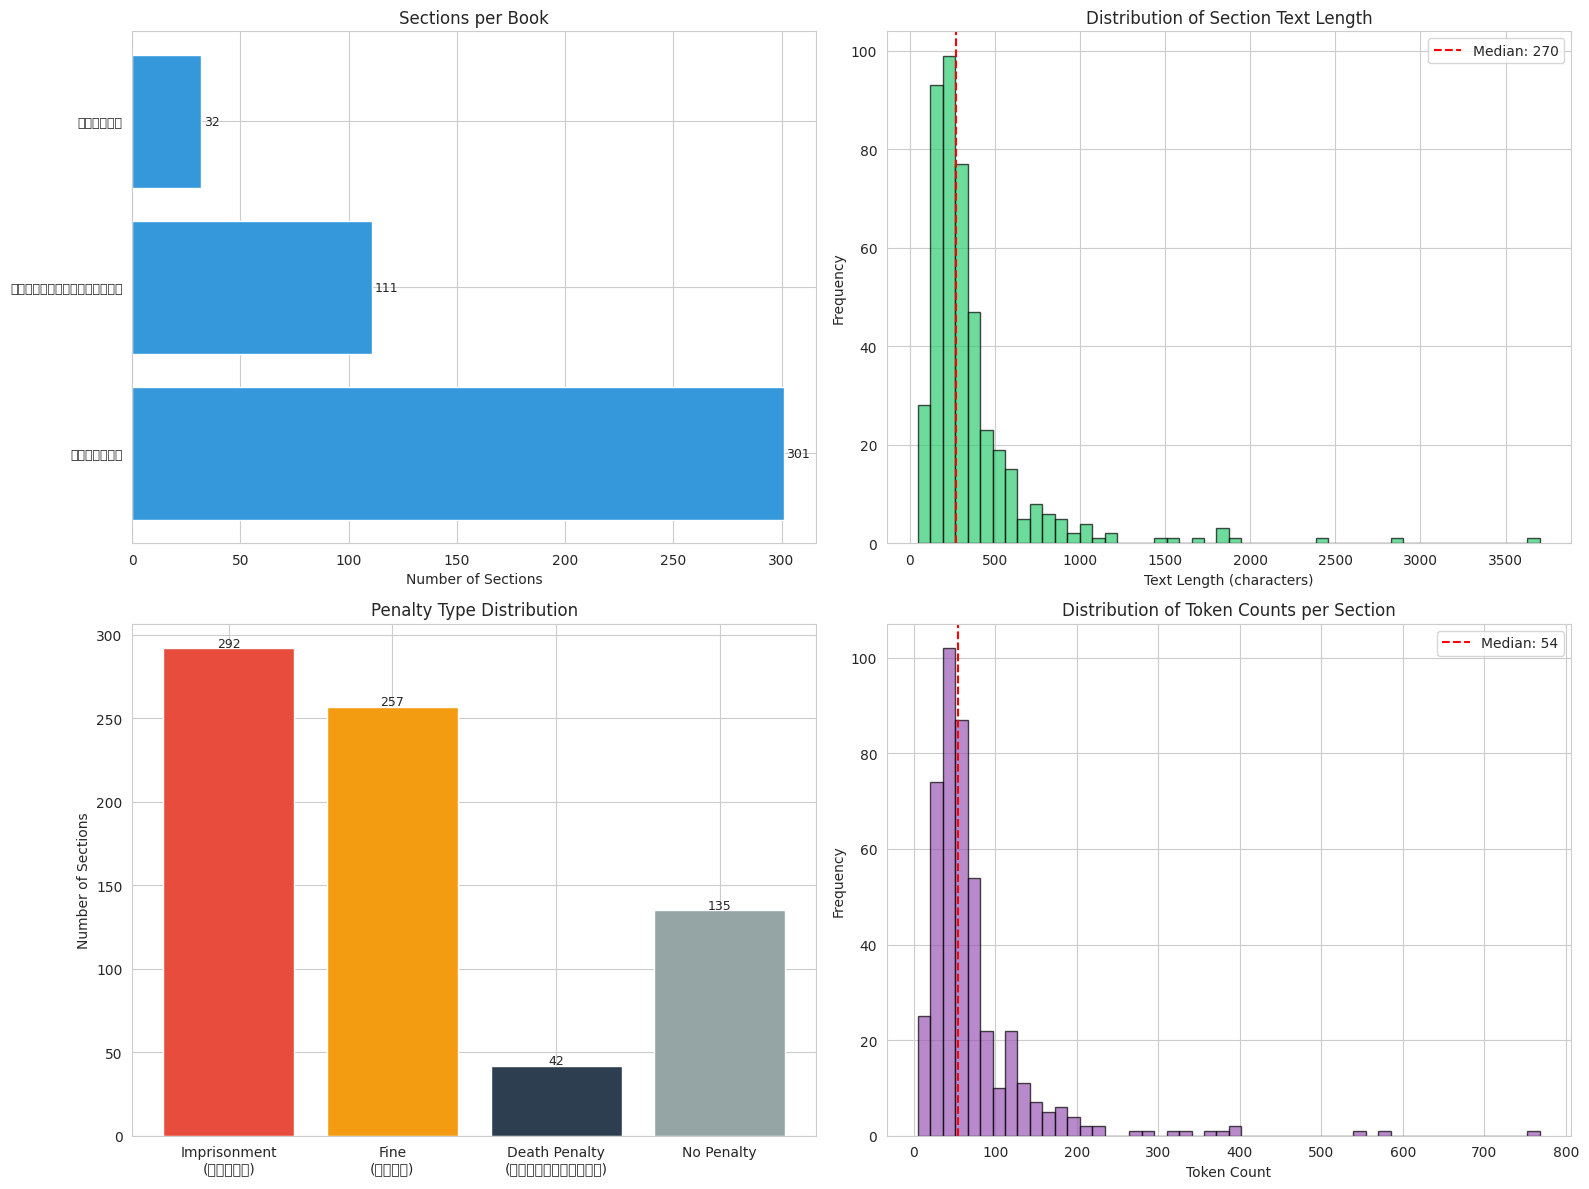

Saved: data/eda_overview.png


In [62]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Articles per Book
book_counts = df_sections.groupby('book_name').size().sort_index()
axes[0, 0].barh(range(len(book_counts)), book_counts.values, color='#3498db')
axes[0, 0].set_yticks(range(len(book_counts)))
axes[0, 0].set_yticklabels(book_counts.index, fontsize=9)
axes[0, 0].set_xlabel('Number of Sections')
axes[0, 0].set_title('Sections per Book')
for i, v in enumerate(book_counts.values):
    axes[0, 0].text(v + 1, i, str(v), va='center', fontsize=9)

# 2. Text length distribution
axes[0, 1].hist(df_sections['text_length'], bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
axes[0, 1].set_xlabel('Text Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Section Text Length')
med = df_sections['text_length'].median()
axes[0, 1].axvline(med, color='red', linestyle='--', label=f'Median: {med:.0f}')
axes[0, 1].legend()

# 3. Penalty type distribution
penalty_data = {
    'Imprisonment\n(จำคุก)': df_sections['has_imprisonment'].sum(),
    'Fine\n(ปรับ)': df_sections['has_fine'].sum(),
    'Death Penalty\n(ประหารชีวิต)': df_sections['has_death_penalty'].sum(),
    'No Penalty': (~(df_sections['has_imprisonment'] | df_sections['has_fine'] | df_sections['has_death_penalty'])).sum()
}
colors = ['#e74c3c', '#f39c12', '#2c3e50', '#95a5a6']
bars = axes[1, 0].bar(penalty_data.keys(), penalty_data.values(), color=colors)
axes[1, 0].set_ylabel('Number of Sections')
axes[1, 0].set_title('Penalty Type Distribution')
for bar, val in zip(bars, penalty_data.values()):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    str(val), ha='center', fontsize=9)

# 4. Token count distribution
axes[1, 1].hist(df_sections['token_count'], bins=50, edgecolor='black', alpha=0.7, color='#9b59b6')
axes[1, 1].set_xlabel('Token Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Token Counts per Section')
med_tok = df_sections['token_count'].median()
axes[1, 1].axvline(med_tok, color='red', linestyle='--', label=f'Median: {med_tok:.0f}')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'eda_overview.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: data/eda_overview.png')

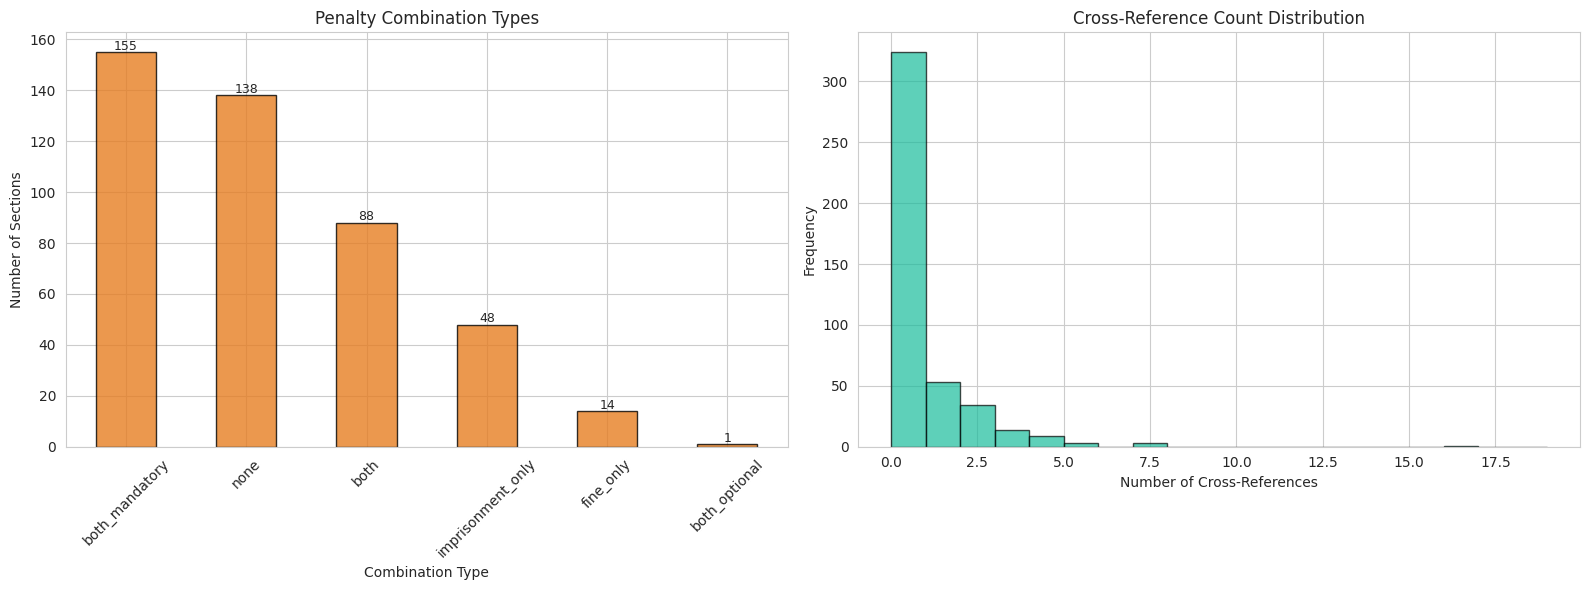

Saved: data/eda_penalties_refs.png


In [63]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Penalty combination distribution
combo_counts = df_sections['penalty_combination'].value_counts()
combo_counts.plot(kind='bar', ax=axes[0], color='#e67e22', edgecolor='black', alpha=0.8)
axes[0].set_title('Penalty Combination Types')
axes[0].set_ylabel('Number of Sections')
axes[0].set_xlabel('Combination Type')
axes[0].tick_params(axis='x', rotation=45)
for i, (idx, val) in enumerate(combo_counts.items()):
    axes[0].text(i, val + 1, str(val), ha='center', fontsize=9)

# 2. Cross-reference distribution
max_refs = min(df_sections['num_cross_refs'].max() + 2, 20)
axes[1].hist(df_sections['num_cross_refs'], bins=range(0, max_refs),
             edgecolor='black', alpha=0.7, color='#1abc9c')
axes[1].set_xlabel('Number of Cross-References')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Cross-Reference Count Distribution')

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'eda_penalties_refs.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: data/eda_penalties_refs.png')

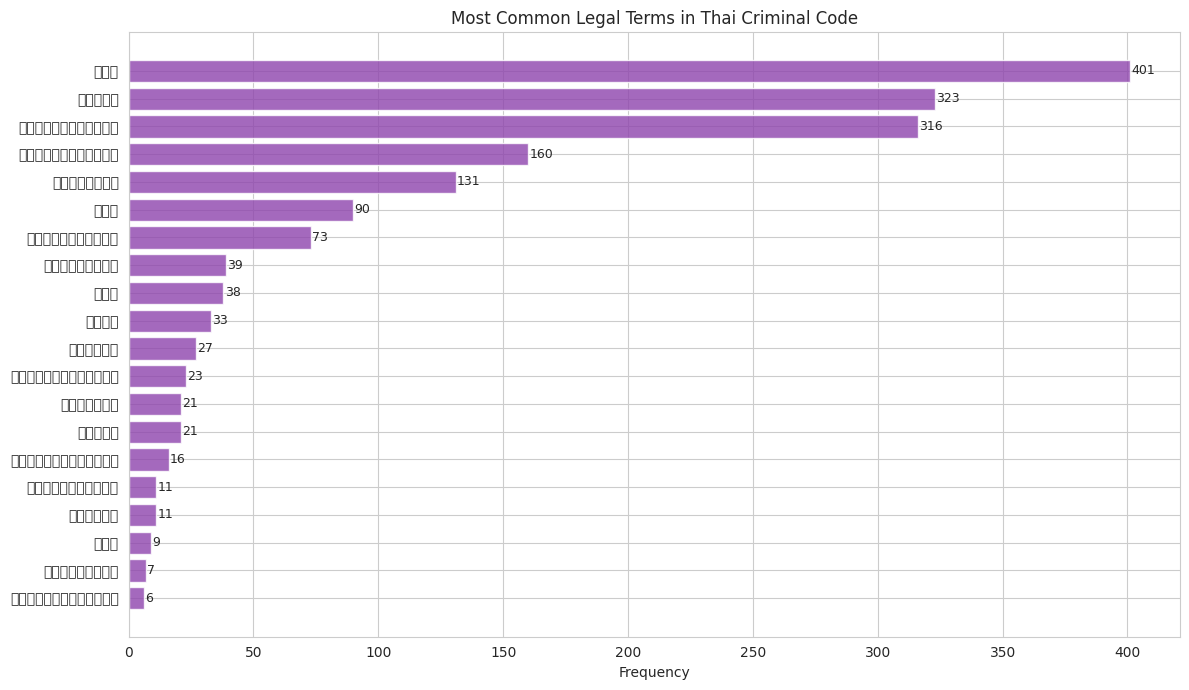

Saved: data/eda_legal_terms.png


In [64]:
# Most common legal terms
all_terms = []
for terms_list in df_sections['entities'].apply(lambda e: e['legal_terms']):
    all_terms.extend(terms_list)

term_counts = Counter(all_terms).most_common(20)

if term_counts:
    fig, ax = plt.subplots(figsize=(12, 7))
    terms, counts = zip(*term_counts)
    y_pos = range(len(terms))
    ax.barh(y_pos, counts, color='#8e44ad', alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(terms, fontsize=10)
    ax.set_xlabel('Frequency')
    ax.set_title('Most Common Legal Terms in Thai Criminal Code')
    ax.invert_yaxis()
    for i, v in enumerate(counts):
        ax.text(v + 0.5, i, str(v), va='center', fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(DATA_DIR, 'eda_legal_terms.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: data/eda_legal_terms.png')
else:
    print('No legal terms found to plot.')

## 10. Save Preprocessed Data

Export all artifacts for the next phases:
- **PageIndex** will use `hierarchy_tree.json`
- **Light Knowledge Graph** will use `entities.json` and `cross_reference_edges.json`
- **Both** will use `preprocessed_criminal_code.csv`

In [65]:
OUTPUT_DIR = os.path.join(DATA_DIR, 'preprocessed')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Main preprocessed CSV
export_cols = [
    'article_id', 'section_num', 'text_clean', 'section_text', 'text_normalized',
    'notes', 'book_num', 'book_name', 'title_num', 'title_name',
    'division_num', 'division_name', 'hierarchy_path', 'text_length', 'token_count',
    'has_imprisonment', 'has_fine', 'has_death_penalty', 'penalty_combination',
    'num_cross_refs', 'num_legal_terms'
]
df_export = df_sections[export_cols].copy()
df_export.to_csv(os.path.join(OUTPUT_DIR, 'preprocessed_criminal_code.csv'), index=False)
print(f'[1/6] Saved preprocessed_criminal_code.csv ({len(df_export)} rows)')

# 2. Hierarchy tree JSON (for PageIndex)
with open(os.path.join(OUTPUT_DIR, 'hierarchy_tree.json'), 'w', encoding='utf-8') as f:
    json.dump(hierarchy_tree, f, ensure_ascii=False, indent=2)
print('[2/6] Saved hierarchy_tree.json')

# 3. Entities JSON (for Light Knowledge Graph)
entities_export = []
for _, row in df_sections.iterrows():
    entities_export.append({
        'section_num': row['section_num'],
        'hierarchy_path': row['hierarchy_path'],
        'entities': row['entities']
    })
with open(os.path.join(OUTPUT_DIR, 'entities.json'), 'w', encoding='utf-8') as f:
    json.dump(entities_export, f, ensure_ascii=False, indent=2)
print(f'[3/6] Saved entities.json ({len(entities_export)} sections)')

# 4. Cross-reference graph (GEXF format)
nx.write_gexf(G_refs, os.path.join(OUTPUT_DIR, 'cross_references.gexf'))
print(f'[4/6] Saved cross_references.gexf ({G_refs.number_of_nodes()} nodes, {G_refs.number_of_edges()} edges)')

# 5. Cross-reference edge list JSON
edges_data = [
    {'source': u, 'target': v, 'relation': d['relation']}
    for u, v, d in G_refs.edges(data=True)
]
with open(os.path.join(OUTPUT_DIR, 'cross_reference_edges.json'), 'w', encoding='utf-8') as f:
    json.dump(edges_data, f, ensure_ascii=False, indent=2)
print(f'[5/6] Saved cross_reference_edges.json ({len(edges_data)} edges)')

# 6. Full parsed DataFrame (including intro sections)
df_parsed.to_csv(os.path.join(OUTPUT_DIR, 'full_parsed_with_headers.csv'), index=False)
print(f'[6/6] Saved full_parsed_with_headers.csv ({len(df_parsed)} rows)')

[1/6] Saved preprocessed_criminal_code.csv (444 rows)
[2/6] Saved hierarchy_tree.json
[3/6] Saved entities.json (444 sections)
[4/6] Saved cross_references.gexf (432 nodes, 360 edges)
[5/6] Saved cross_reference_edges.json (360 edges)
[6/6] Saved full_parsed_with_headers.csv (452 rows)


In [66]:
# Final summary
print('=' * 60)
print('DATA COLLECTION & PREPROCESSING COMPLETE')
print('=' * 60)
print(f'''
Dataset Summary:
  Raw CSV rows:                {len(df_raw)}
  Legal sections (มาตรา):       {len(df_sections)}
  Books (ภาค):                  {df_sections['book_num'].nunique()}
  Titles (ลักษณะ):              {df_sections['title_num'].dropna().nunique()}
  Divisions (หมวด):             {df_sections['division_num'].dropna().nunique()}

Entity Extraction:
  With imprisonment penalty:   {df_sections['has_imprisonment'].sum()}
  With fine penalty:           {df_sections['has_fine'].sum()}
  With death penalty:          {df_sections['has_death_penalty'].sum()}
  Total cross-references:      {df_sections['num_cross_refs'].sum()}
  Cross-reference graph:       {G_refs.number_of_nodes()} nodes, {G_refs.number_of_edges()} edges

Output Files (in data/preprocessed/):
  preprocessed_criminal_code.csv  -> Main dataset for PageIndex + KG
  hierarchy_tree.json             -> Tree structure for PageIndex
  entities.json                   -> Entity data for Light KG
  cross_references.gexf           -> Cross-reference graph (GEXF)
  cross_reference_edges.json      -> Edge list for KG
  full_parsed_with_headers.csv    -> Complete parsed data

Next Steps (Task 3 - Model Development):
  1. Build PageIndex tree from hierarchy_tree.json
  2. Construct Light Knowledge Graph from entities.json + edges
  3. Implement retrieval pipeline for Q&A
''')

# List output files with sizes
print('Output file sizes:')
for f in sorted(os.listdir(OUTPUT_DIR)):
    fpath = os.path.join(OUTPUT_DIR, f)
    size = os.path.getsize(fpath)
    print(f'  {f}: {size / 1024:.1f} KB')

DATA COLLECTION & PREPROCESSING COMPLETE

Dataset Summary:
  Raw CSV rows:                453
  Legal sections (มาตรา):       444
  Books (ภาค):                  3
  Titles (ลักษณะ):              13
  Divisions (หมวด):             11

Entity Extraction:
  With imprisonment penalty:   292
  With fine penalty:           257
  With death penalty:          42
  Total cross-references:      366
  Cross-reference graph:       432 nodes, 360 edges

Output Files (in data/preprocessed/):
  preprocessed_criminal_code.csv  -> Main dataset for PageIndex + KG
  hierarchy_tree.json             -> Tree structure for PageIndex
  entities.json                   -> Entity data for Light KG
  cross_references.gexf           -> Cross-reference graph (GEXF)
  cross_reference_edges.json      -> Edge list for KG
  full_parsed_with_headers.csv    -> Complete parsed data

Next Steps (Task 3 - Model Development):
  1. Build PageIndex tree from hierarchy_tree.json
  2. Construct Light Knowledge Graph from entiti

---
---
# Task 3: Model Development

Everything below uses the preprocessed data from Task 2 above.

# Task 3: Model Development

## Comparing PageIndex vs PageIndex + Light Knowledge Graph for Thai Criminal Law Q&A Chatbot

**Course:** CS652 Applied Machine Learning  
**Student:** 6809036087  
**LLM:** Qwen3:8b via Ollama (local inference)

---

### Architecture

```
Query → Pipeline A (PageIndex Only)    → Retrieved Sections → Qwen3 → Answer
Query → Pipeline B (PageIndex + KG)    → Retrieved Sections → Qwen3 → Answer
```

### Notebook Sections
1. Setup & Dependencies
2. Build PageIndex Tree Structure
3. Generate Node Summaries (Bottom-Up with Qwen3)
4. Build Light Knowledge Graph
5. Pipeline A: PageIndex Retrieval
6. Pipeline B: PageIndex + KG Retrieval
7. Evaluation Framework
8. Run Evaluation & Compare
9. Analysis & Discussion
10. Save Results

---
## 1. Setup & Dependencies

In [67]:
import json
import os
import re
import time
import copy
from collections import defaultdict, Counter
from pathlib import Path

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import ollama

# Configure matplotlib for Thai text
thai_fonts = [f.name for f in matplotlib.font_manager.fontManager.ttflist
              if 'Tahoma' in f.name or 'Sarabun' in f.name or 'Garuda' in f.name
              or 'Loma' in f.name or 'TH ' in f.name or 'Angsana' in f.name
              or 'Browallia' in f.name or 'Cordia' in f.name]

if thai_fonts:
    plt.rcParams['font.family'] = thai_fonts[0]
    print(f"Using Thai font: {thai_fonts[0]}")
else:
    print("No Thai font found, using default font")

plt.rcParams['axes.unicode_minus'] = False

print("All imports loaded successfully")

No Thai font found, using default font
All imports loaded successfully


In [68]:
# Verify LLM model is available
# Auto-detect: prefer qwen3, fall back to llama3.2
models = ollama.list()
model_names = [m.model for m in models.models]
print("Available Ollama models:", model_names)

MODEL_NAME = None
for candidate in ["qwen3:8b", "qwen3:8b", "qwen3:latest", "llama3.2:latest", "llama3.2:1b"]:
    if any(candidate in name for name in model_names):
        MODEL_NAME = candidate
        break

if MODEL_NAME is None:
    print("\n⚠ No supported model found! Please run one of:")
    print("  ollama pull qwen3:8b     (recommended, ~5 GB)")
    print("  ollama pull qwen3:8b     (smaller, ~2.5 GB)")
    print("  ollama pull llama3.2     (fallback, ~2 GB)")
    raise RuntimeError("No supported model available")

print(f"\n✓ Using model: {MODEL_NAME}")
if "llama" in MODEL_NAME:
    print("  Note: Using Llama 3.2. Thai support may be limited compared to Qwen3.")

Available Ollama models: ['qwen3:8b']

✓ Using model: qwen3:8b


In [69]:
# Load all preprocessed data from Task 2
DATA_DIR = Path("data/preprocessed")
RESULTS_DIR = Path("data/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

with open(DATA_DIR / "hierarchy_tree.json", "r", encoding="utf-8") as f:
    hierarchy_tree = json.load(f)

with open(DATA_DIR / "entities.json", "r", encoding="utf-8") as f:
    entities_data = json.load(f)

with open(DATA_DIR / "cross_reference_edges.json", "r", encoding="utf-8") as f:
    cross_ref_edges = json.load(f)

with open(DATA_DIR / "qa_test_dataset.json", "r", encoding="utf-8") as f:
    qa_dataset = json.load(f)

df = pd.read_csv(DATA_DIR / "preprocessed_criminal_code.csv")

print(f"Hierarchy tree: root with {len(hierarchy_tree['children'])} books")
print(f"Entities: {len(entities_data)} sections")
print(f"Cross-reference edges: {len(cross_ref_edges)} edges")
print(f"Q&A dataset: {len(qa_dataset)} questions")
print(f"Preprocessed CSV: {df.shape[0]} rows, {df.shape[1]} columns")

Hierarchy tree: root with 3 books
Entities: 444 sections
Cross-reference edges: 360 edges
Q&A dataset: 20 questions
Preprocessed CSV: 444 rows, 21 columns


In [70]:
# Helper function to call Qwen3
def ask_qwen3(prompt, temperature=0.3, max_retries=3):
    """Call Qwen3 via Ollama with retry logic."""
    for attempt in range(max_retries):
        try:
            response = ollama.chat(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                options={"temperature": temperature, "num_predict": 1024}
            )
            text = response["message"]["content"]
            # Remove <think>...</think> blocks if present (Qwen3 thinking mode)
            text = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL).strip()
            return text
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2) # Wait before retrying
            else:
                print(f"Error calling Qwen3: {e}")
                return ""

# Quick test
test_response = ask_qwen3("สวัสดีครับ ตอบสั้นๆ ว่าคุณคือใคร")
print("Test response:", test_response[:200])

Test response: สวัสดีครับ! ผมคือ Qwen ซึ่งเป็นโมเดลภาษาขนาดใหญ่ที่พัฒนาโดย Alibaba Cloud สามารถช่วยเหลือและตอบคำถามได้หลากหลายด้านครับ!


---
## 2. Build PageIndex Tree Structure

Convert the hierarchy JSON into a navigable tree with parent/child links and unique node IDs.

In [71]:
class TreeNode:
    """A node in the PageIndex tree."""
    def __init__(self, node_id, level, name, text="", parent=None):
        self.node_id = node_id
        self.level = level        # root, book, title, division, section
        self.name = name
        self.text = text           # full legal text (sections only)
        self.summary = ""          # LLM-generated summary
        self.parent = parent
        self.children = []
        self.section_num = None    # for leaf nodes

    def __repr__(self):
        return f"TreeNode({self.node_id}, {self.level}, {self.name[:40]}...)"


def build_tree(tree_data):
    """Build navigable tree from hierarchy_tree.json."""
    nodes = {}  # node_id -> TreeNode

    # Create root
    root = TreeNode("root", "root", tree_data["root"])
    nodes["root"] = root

    def add_children(parent_node, children_data):
        for child_data in children_data:
            child_type = child_data["type"]

            if child_type == "section":
                node_id = f"section_{child_data['number']}"
                name = f"มาตรา {child_data['number']}"
                text = child_data.get("full_text", child_data.get("text", ""))
                node = TreeNode(node_id, "section", name, text, parent_node)
                node.section_num = str(child_data["number"])
            else:
                num = child_data.get("number", "")
                name = child_data.get("name", f"{child_type} {num}")
                node_id = f"{child_type}_{num}"
                node = TreeNode(node_id, child_type, name, parent=parent_node)

            nodes[node_id] = node
            parent_node.children.append(node)

            if "children" in child_data and child_data["children"]:
                add_children(node, child_data["children"])

    add_children(root, tree_data["children"])
    return root, nodes


root, all_nodes = build_tree(hierarchy_tree)

# Count nodes by level
level_counts = Counter(n.level for n in all_nodes.values())
print("Tree node counts by level:")
for level, count in sorted(level_counts.items()):
    print(f"  {level}: {count}")
print(f"\nTotal nodes: {len(all_nodes)}")

Tree node counts by level:
  book: 3
  division: 11
  root: 1
  section: 431
  title: 13

Total nodes: 459


In [72]:
# Verify tree structure by printing top 2 levels
print(f"Root: {root.name}")
for book in root.children:
    print(f"  ├── {book.name} ({len(book.children)} titles)")
    for title in book.children[:3]:
        n_div = len(title.children)
        n_sec = sum(len(d.children) for d in title.children if d.level == 'division')
        # Some titles have sections directly (no division)
        n_sec += sum(1 for c in title.children if c.level == 'section')
        print(f"  │   ├── {title.name} ({n_div} children, ~{n_sec} sections)")
    if len(book.children) > 3:
        print(f"  │   └── ... and {len(book.children) - 3} more titles")

Root: ประมวลกฎหมายอาญา
  ├── ภาค 1 บทบัญญัติทั่วไป (2 titles)
  │   ├── ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป (11 children, ~106 sections)
  │   ├── ลักษณะ 2 บทบัญญัติที่ใช้แก่ความผิดลหุโทษ (5 children, ~5 sections)
  ├── ภาค 2 ความผิด (13 titles)
  │   ├── ลักษณะ 1 ความผิดเกี่ยวกับความมั่นคงแห่งราชอาณาจักร (4 children, ~29 sections)
  │   ├── ลักษณะ 1/1 ความผิดเกี่ยวกับการก่อการร้าย (4 children, ~4 sections)
  │   ├── ลักษณะ 2 ความผิดเกี่ยวกับการปกครอง (2 children, ~31 sections)
  │   └── ... and 10 more titles
  ├── ภาค 3 ลหุโทษ (32 titles)
  │   ├── มาตรา 367 (0 children, ~0 sections)
  │   ├── มาตรา 368 (0 children, ~0 sections)
  │   ├── มาตรา 369 (0 children, ~0 sections)
  │   └── ... and 29 more titles


---
## 3. Generate Node Summaries (Bottom-Up with Qwen3)

Generate Thai summaries for each node, starting from leaf sections and building up. Summaries are cached to avoid re-generation.

In [73]:
SUMMARIES_PATH = DATA_DIR / "node_summaries.json"

# Load cached summaries if they exist
if SUMMARIES_PATH.exists():
    with open(SUMMARIES_PATH, "r", encoding="utf-8") as f:
        cached_summaries = json.load(f)
    print(f"Loaded {len(cached_summaries)} cached summaries")
else:
    cached_summaries = {}
    print("No cached summaries found, will generate from scratch")

Loaded 459 cached summaries


In [74]:
def summarize_section(node):
    """Summarize a leaf section node."""
    prompt = f"""สรุปมาตรากฎหมายต่อไปนี้ให้สั้นกระชับ 1-2 ประโยค เป็นภาษาไทย ระบุสาระสำคัญและบทลงโทษ (ถ้ามี):

{node.text[:1500]}

สรุป:"""
    return ask_qwen3(prompt, temperature=0.2)


def summarize_parent(node, children_summaries):
    """Summarize a parent node from its children's summaries."""
    summaries_text = "\n".join([
        f"- {child.name}: {summary}"
        for child, summary in children_summaries
    ])

    # Truncate if too long
    if len(summaries_text) > 3000:
        summaries_text = summaries_text[:3000] + "\n... (ตัดทอน)"

    prompt = f"""สรุปภาพรวมของ "{node.name}" จากเนื้อหาย่อยต่อไปนี้ ให้สั้นกระชับ 2-3 ประโยค เป็นภาษาไทย:

{summaries_text}

สรุปภาพรวม:"""
    return ask_qwen3(prompt, temperature=0.2)


def generate_all_summaries(root_node, nodes_dict, cached):
    """Generate summaries bottom-up for all nodes."""
    total = len(nodes_dict)
    generated = 0
    skipped = 0

    def process_node(node):
        nonlocal generated, skipped

        # Check cache first
        if node.node_id in cached:
            node.summary = cached[node.node_id]
            skipped += 1
            # Still need to process children for their summaries
            for child in node.children:
                process_node(child)
            return node.summary

        # Process children first (bottom-up)
        children_summaries = []
        for child in node.children:
            child_summary = process_node(child)
            children_summaries.append((child, child_summary))

        # Generate summary
        if node.level == "section":
            node.summary = summarize_section(node)
        elif node.level == "root":
            node.summary = summarize_parent(node, children_summaries)
        elif children_summaries:
            node.summary = summarize_parent(node, children_summaries)
        else:
            node.summary = node.name

        # Cache immediately
        cached[node.node_id] = node.summary
        generated += 1

        if generated % 20 == 0:
            print(f"  Generated {generated}/{total - skipped} summaries...")
            # Save intermediate cache
            with open(SUMMARIES_PATH, "w", encoding="utf-8") as f:
                json.dump(cached, f, ensure_ascii=False, indent=2)

        return node.summary

    process_node(root_node)

    # Final save
    with open(SUMMARIES_PATH, "w", encoding="utf-8") as f:
        json.dump(cached, f, ensure_ascii=False, indent=2)

    print(f"\nDone! Generated: {generated}, Cached: {skipped}, Total: {total}")
    return cached

In [75]:
# Generate summaries (this takes ~30-60 minutes on first run)
print("Generating node summaries (bottom-up)...")
print("This may take a while on first run. Summaries are cached for future use.\n")

start_time = time.time()
cached_summaries = generate_all_summaries(root, all_nodes, cached_summaries)
elapsed = time.time() - start_time

print(f"\nTime elapsed: {elapsed/60:.1f} minutes")
print(f"Summaries saved to: {SUMMARIES_PATH}")

Generating node summaries (bottom-up)...
This may take a while on first run. Summaries are cached for future use.


Done! Generated: 0, Cached: 501, Total: 459

Time elapsed: 0.0 minutes
Summaries saved to: data/preprocessed/node_summaries.json


In [76]:
# Show sample summaries at each level
print("=== Sample Summaries ===")
print(f"\n[Root] {root.name}:")
print(f"  {root.summary[:200]}")

if root.children:
    book = root.children[0]
    print(f"\n[Book] {book.name}:")
    print(f"  {book.summary[:200]}")

    if book.children:
        title = book.children[0]
        print(f"\n[Title] {title.name}:")
        print(f"  {title.summary[:200]}")

        if title.children:
            div_or_sec = title.children[0]
            print(f"\n[{div_or_sec.level.title()}] {div_or_sec.name}:")
            print(f"  {div_or_sec.summary[:200]}")

=== Sample Summaries ===

[Root] ประมวลกฎหมายอาญา:
  ประมวลกฎหมายอาญาไทยแบ่งออกเป็น 3 ภาค ได้แก่

1. **ภาค 1 บทบัญญัติทั่วไป**: มีบทบัญญัติความผิดทั่วไปและบทบัญญัติความผิดลหุโ
2. **ภาค 2 ความผิด**: มีความผิดต่อองค์พระมหากษัตริย์ พระราชินี รัชทายาท และอื

[Book] ภาค 1 บทบัญญัติทั่วไป:
  บทบัญญัติอาญาไทยแบ่งออกเป็น 2 ประเภทหลัก ได้แก่ 

1. บทบัญญัติความผิดทั่วไป 
2. บทบัญญัติความผิดลหุโทษ

[Title] ลักษณะ 1 บทบัญญัติที่ใช้แก่ความผิดทั่วไป:
  ตามกฎหมายอาญาของไทย มีลักษณะความผิดดังนี้:

1. ความผิดต่อองค์พระมหากษัตริย์ พระราชินี รัชทายาท และผู้สำเร็จราชการแทนพระองค์: 
   - ความผิดต่อองค์พระมหากษัตริย์และพระราชวงศ์
   - ความผิดต่อผู้มีส่วนร่ว

[Division] หมวด 1.0 บทนิยาม:
  ตามมาตรา 334-336 ของประมวลกฎหมายอาญาไทย ผู้ที่กระทำการลักทรัพย์หรือทุจริตต้องระวางโทษจำคุกและปรับตามความเหมาะสม โดยเฉพาะอย่างยิ่งผู้ที่กระทำการลักพระพุทธรูปหรือวัตถุในทางศาสนาต้องระวางโทษจำคุกและปรับท


---
## 4. Build Light Knowledge Graph

Create a NetworkX directed graph with section nodes, cross-reference edges, and entity attributes.

In [77]:
# Build Knowledge Graph
kg = nx.DiGraph()

# Build section lookup from DataFrame
section_texts = {}
for _, row in df.iterrows():
    sec_num = str(row['section_num'])
    section_texts[sec_num] = row.get('section_text', row.get('text_clean', ''))

# Add nodes from entities data
for entity in entities_data:
    sec_num = str(entity["section_num"])
    kg.add_node(sec_num,
                hierarchy_path=entity["hierarchy_path"],
                penalties=[p["type"] for p in entity["entities"]["penalties"]],
                penalty_combination=entity["entities"]["penalty_combination"],
                legal_terms=entity["entities"]["legal_terms"],
                has_exception=entity["entities"]["has_exception"],
                has_condition=entity["entities"]["has_condition"],
                text=section_texts.get(sec_num, ""))

# Add cross-reference edges
for edge in cross_ref_edges:
    src = str(edge["source"])
    tgt = str(edge["target"])
    if src in kg.nodes and tgt in kg.nodes:
        kg.add_edge(src, tgt, relation="references")

print(f"Knowledge Graph:")
print(f"  Nodes: {kg.number_of_nodes()}")
print(f"  Edges (cross-references): {kg.number_of_edges()}")
print(f"  Average out-degree: {sum(d for _, d in kg.out_degree()) / kg.number_of_nodes():.2f}")
print(f"  Nodes with cross-refs: {sum(1 for _, d in kg.out_degree() if d > 0)}")

Knowledge Graph:
  Nodes: 431
  Edges (cross-references): 359
  Average out-degree: 0.83
  Nodes with cross-refs: 116


In [78]:
# Build division membership lookup for thematic expansion
section_to_division = {}
division_sections = defaultdict(list)

for entity in entities_data:
    sec_num = str(entity["section_num"])
    path = entity["hierarchy_path"]
    # Extract division from hierarchy path
    parts = path.split(" > ")
    if len(parts) >= 3:
        division = parts[2]  # e.g., "หมวด 1: บทนิยาม"
    else:
        division = parts[-1]
    section_to_division[sec_num] = division
    division_sections[division].append(sec_num)

print(f"Division groups: {len(division_sections)}")
print(f"Average sections per division: {np.mean([len(v) for v in division_sections.values()]):.1f}")

Division groups: 135
Average sections per division: 3.3


In [79]:
# KG query functions

def get_cross_refs(section_num, hops=1):
    """Get cross-referenced sections (1-hop neighbors)."""
    section_num = str(section_num)
    if section_num not in kg:
        return []

    refs = set()
    current = {section_num}
    for _ in range(hops):
        next_hop = set()
        for node in current:
            # Outgoing references
            next_hop.update(kg.successors(node))
            # Incoming references
            next_hop.update(kg.predecessors(node))
        refs.update(next_hop)
        current = next_hop

    refs.discard(section_num)
    return list(refs)


def get_penalty_info(section_num):
    """Get penalty information for a section."""
    section_num = str(section_num)
    if section_num not in kg:
        return {}
    data = kg.nodes[section_num]
    return {
        "penalties": data.get("penalties", []),
        "combination": data.get("penalty_combination", "none")
    }


def get_same_division_sections(section_num, max_sections=5):
    """Get other sections in the same division."""
    section_num = str(section_num)
    division = section_to_division.get(section_num)
    if not division:
        return []
    siblings = [s for s in division_sections[division] if s != section_num]
    return siblings[:max_sections]


# Test KG functions
test_sec = "334"  # ลักทรัพย์ (theft)
print(f"Test section: มาตรา {test_sec}")
print(f"  Cross-refs: {get_cross_refs(test_sec)}")
print(f"  Penalties: {get_penalty_info(test_sec)}")
print(f"  Same division: {get_same_division_sections(test_sec)}")

Test section: มาตรา 334
  Cross-refs: ['335', '41', '71', '8', '93', '336']
  Penalties: {'penalties': ['imprisonment', 'fine'], 'combination': 'both'}
  Same division: ['335', '335', '336', '336']


---
## 5. Pipeline A: PageIndex Retrieval

Tree-based retrieval: Start at root, ask LLM which branch is most relevant at each level (beam width = 2), descend to leaf sections.

In [80]:
def pageindex_retrieve(query, root_node, beam_width=2, verbose=False):
    """
    PageIndex tree traversal retrieval.
    At each level, ask Qwen3 to select the top-k most relevant branches.
    Returns list of retrieved section TreeNodes.
    """
    current_nodes = [root_node]
    retrieved_sections = []

    while current_nodes:
        next_level_nodes = []

        for node in current_nodes:
            if not node.children:
                # Leaf node (section) - add to results
                if node.level == "section":
                    retrieved_sections.append(node)
                continue

            # If all children are sections, include all (already at leaf level)
            if all(c.level == "section" for c in node.children):
                # Ask LLM to pick most relevant sections
                choices = "\n".join([
                    f"{i+1}. {c.name}: {c.summary[:150]}"
                    for i, c in enumerate(node.children)
                ])

                prompt = f"""คำถาม: {query}

เลือกมาตราที่เกี่ยวข้องกับคำถามมากที่สุด (เลือกได้หลายข้อ ไม่เกิน {min(beam_width + 1, len(node.children))} ข้อ)
ตอบเป็นตัวเลขคั่นด้วยเครื่องหมายจุลภาค เช่น 1,3,5

ตัวเลือก:
{choices}

ตอบเฉพาะตัวเลข:"""

                response = ask_qwen3(prompt, temperature=0.1)
                selected = parse_selection(response, len(node.children))

                if not selected:
                    selected = list(range(min(beam_width, len(node.children))))

                for idx in selected[:beam_width + 1]:
                    retrieved_sections.append(node.children[idx])

                if verbose:
                    print(f"  [{node.name}] Selected sections: {[node.children[i].name for i in selected[:beam_width+1]]}")
                continue

            # Non-leaf: ask LLM to choose branches
            choices = "\n".join([
                f"{i+1}. {c.name}: {c.summary[:150]}"
                for i, c in enumerate(node.children)
            ])

            prompt = f"""คำถาม: {query}

เลือกหัวข้อที่เกี่ยวข้องกับคำถามมากที่สุด (เลือกได้ {min(beam_width, len(node.children))} ข้อ)
ตอบเป็นตัวเลขคั่นด้วยเครื่องหมายจุลภาค เช่น 1,3

ตัวเลือก:
{choices}

ตอบเฉพาะตัวเลข:"""

            response = ask_qwen3(prompt, temperature=0.1)
            selected = parse_selection(response, len(node.children))

            if not selected:
                selected = list(range(min(beam_width, len(node.children))))

            for idx in selected[:beam_width]:
                next_level_nodes.append(node.children[idx])

            if verbose:
                print(f"  [{node.level}] {node.name} -> Selected: {[node.children[i].name for i in selected[:beam_width]]}")

        current_nodes = next_level_nodes

    return retrieved_sections


def parse_selection(response, max_options):
    """Parse LLM selection response into list of 0-based indices."""
    numbers = re.findall(r'\d+', response)
    indices = []
    for n in numbers:
        idx = int(n) - 1  # Convert to 0-based
        if 0 <= idx < max_options:
            indices.append(idx)
    return list(dict.fromkeys(indices))  # Deduplicate preserving order

In [81]:
def generate_answer(query, retrieved_sections, pipeline_name=""):
    """Generate answer from retrieved sections using Qwen3."""
    # Build context from retrieved sections
    context_parts = []
    for node in retrieved_sections:
        text = node.text if node.text else node.summary
        context_parts.append(f"{node.name}: {text}")

    context = "\n\n".join(context_parts)

    # Truncate context if too long
    if len(context) > 4000:
        context = context[:4000] + "\n... (ตัดทอน)"

    prompt = f"""คุณเป็นผู้เชี่ยวชาญด้านกฎหมายอาญาไทย ตอบคำถามต่อไปนี้โดยอ้างอิงจากประมวลกฎหมายอาญาที่ให้มา
ตอบเป็นภาษาไทย ให้ครบถ้วนและถูกต้อง อ้างอิงเลขมาตราที่เกี่ยวข้อง

=== บทบัญญัติที่เกี่ยวข้อง ===
{context}

=== คำถาม ===
{query}

=== คำตอบ ==="""

    return ask_qwen3(prompt, temperature=0.3)


def pipeline_a(query, verbose=False):
    """Full Pipeline A: PageIndex retrieval + answer generation."""
    start = time.time()

    # Retrieve
    retrieved = pageindex_retrieve(query, root, beam_width=2, verbose=verbose)

    # Generate answer
    answer = generate_answer(query, retrieved, "Pipeline A")

    elapsed = time.time() - start

    return {
        "answer": answer,
        "retrieved_sections": [n.section_num for n in retrieved if n.section_num],
        "retrieved_names": [n.name for n in retrieved],
        "latency": elapsed
    }

In [ ]:
# Test Pipeline A with a sample question
test_query = qa_dataset[0]["question"]  # ความผิดฐานลักทรัพย์มีโทษอย่างไร?
print(f"Test query: {test_query}")
print(f"Expected sections: {qa_dataset[0]['reference_sections']}")
print()

result_a = pipeline_a(test_query, verbose=True)
print(f"\nRetrieved sections: {result_a['retrieved_sections']}")
print(f"Latency: {result_a['latency']:.1f}s")
print(f"\nAnswer: {result_a['answer']}")

Test query: ความผิดฐานลักทรัพย์มีโทษอย่างไร?
Expected sections: ['334']



---
## 6. Pipeline B: PageIndex + KG Retrieval

Same PageIndex traversal, then expand retrieved sections using Knowledge Graph (cross-references, same-division siblings).

In [ ]:
def kg_expand(retrieved_sections, max_expansion=5):
    """
    Expand retrieved sections using Knowledge Graph.
    - Follow cross-reference edges (1-hop)
    - Add same-division siblings for context
    Returns expanded list of section numbers.
    """
    original_sections = set(n.section_num for n in retrieved_sections if n.section_num)
    expanded = set(original_sections)

    for sec_num in original_sections:
        # Cross-reference expansion
        cross_refs = get_cross_refs(sec_num, hops=1)
        expanded.update(cross_refs[:3])  # Limit per section

        # Same-division siblings (for comparison questions)
        siblings = get_same_division_sections(sec_num, max_sections=2)
        expanded.update(siblings)

    # Limit total expansion
    expanded = list(expanded)
    if len(expanded) > len(original_sections) + max_expansion:
        # Keep originals + top expansion by relevance (degree in KG)
        new_sections = [s for s in expanded if s not in original_sections]
        new_sections.sort(key=lambda s: kg.degree(s) if s in kg else 0, reverse=True)
        expanded = list(original_sections) + new_sections[:max_expansion]

    return expanded


def sections_to_nodes(section_nums):
    """Convert section numbers to TreeNodes (or create minimal nodes)."""
    nodes = []
    for sec_num in section_nums:
        node_id = f"section_{sec_num}"
        if node_id in all_nodes:
            nodes.append(all_nodes[node_id])
        elif sec_num in kg:
            # Create a minimal node from KG data
            node = TreeNode(node_id, "section", f"มาตรา {sec_num}",
                          kg.nodes[sec_num].get("text", ""))
            node.section_num = sec_num
            nodes.append(node)
    return nodes


def pipeline_b(query, verbose=False):
    """Full Pipeline B: PageIndex + KG retrieval + answer generation."""
    start = time.time()

    # Step 1: PageIndex retrieval (same as Pipeline A)
    retrieved = pageindex_retrieve(query, root, beam_width=2, verbose=verbose)

    # Step 2: KG expansion
    expanded_sections = kg_expand(retrieved, max_expansion=5)

    if verbose:
        original = set(n.section_num for n in retrieved if n.section_num)
        new_from_kg = set(expanded_sections) - original
        print(f"  [KG] Original: {original}, Added: {new_from_kg}")

    # Step 3: Convert back to nodes for answer generation
    expanded_nodes = sections_to_nodes(expanded_sections)

    # Step 4: Generate answer with expanded context
    answer = generate_answer(query, expanded_nodes, "Pipeline B")

    elapsed = time.time() - start

    return {
        "answer": answer,
        "retrieved_sections": expanded_sections,
        "original_sections": [n.section_num for n in retrieved if n.section_num],
        "kg_added_sections": list(set(expanded_sections) - set(n.section_num for n in retrieved if n.section_num)),
        "retrieved_names": [f"มาตรา {s}" for s in expanded_sections],
        "latency": elapsed
    }

In [ ]:
# Test Pipeline B with the same question
print(f"Test query: {test_query}")
print(f"Expected sections: {qa_dataset[0]['reference_sections']}")
print()

result_b = pipeline_b(test_query, verbose=True)
print(f"\nRetrieved sections (total): {result_b['retrieved_sections']}")
print(f"  Original from PageIndex: {result_b['original_sections']}")
print(f"  Added by KG: {result_b['kg_added_sections']}")
print(f"Latency: {result_b['latency']:.1f}s")
print(f"\nAnswer: {result_b['answer']}")

In [ ]:
print(result_b['answer'])

---
## 7. Evaluation Framework

Evaluate both pipelines on 20 test questions. Metrics: retrieval recall/precision, answer quality (LLM-as-judge), latency.

In [ ]:
def compute_retrieval_metrics(retrieved_sections, ground_truth_sections):
    """Compute retrieval precision and recall."""
    retrieved = set(str(s) for s in retrieved_sections)
    ground_truth = set(str(s) for s in ground_truth_sections)

    if not ground_truth:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}

    true_positives = retrieved & ground_truth

    precision = len(true_positives) / len(retrieved) if retrieved else 0.0
    recall = len(true_positives) / len(ground_truth) if ground_truth else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return {"precision": precision, "recall": recall, "f1": f1}


def llm_judge_answer(question, generated_answer, ground_truth_answer):
    """Use Qwen3 as a judge to score answer quality (1-5)."""
    prompt = f"""ให้คะแนนคำตอบต่อไปนี้ เทียบกับคำตอบที่ถูกต้อง (1-5 คะแนน)

เกณฑ์การให้คะแนน:
5 = ถูกต้องครบถ้วน ตรงกับคำตอบที่ถูกต้อง
4 = ถูกต้องเป็นส่วนใหญ่ ขาดรายละเอียดเล็กน้อย
3 = ถูกต้องบางส่วน มีข้อมูลหลักถูกต้อง
2 = ถูกต้องเล็กน้อย ขาดข้อมูลสำคัญมาก
1 = ไม่ถูกต้อง หรือไม่เกี่ยวข้อง

คำถาม: {question}

คำตอบที่ถูกต้อง: {ground_truth_answer}

คำตอบที่ต้องประเมิน: {generated_answer}

ตอบเป็นตัวเลข 1-5 เท่านั้น:"""

    response = ask_qwen3(prompt, temperature=0.1)
    # Extract score
    numbers = re.findall(r'[1-5]', response)
    return int(numbers[0]) if numbers else 3  # Default to 3 if parsing fails


print("Evaluation framework ready.")
print(f"Q&A dataset: {len(qa_dataset)} questions")
print(f"Question types: {Counter(q['question_type'] for q in qa_dataset)}")
print(f"Difficulty levels: {Counter(q['difficulty'] for q in qa_dataset)}")